In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate as interp
from scipy import integrate 
from scipy import stats 
from tqdm.notebook import tqdm
import time
from IPython.display import display, Latex
import corner
%matplotlib notebook


Data size:  100000


<IPython.core.display.Javascript object>


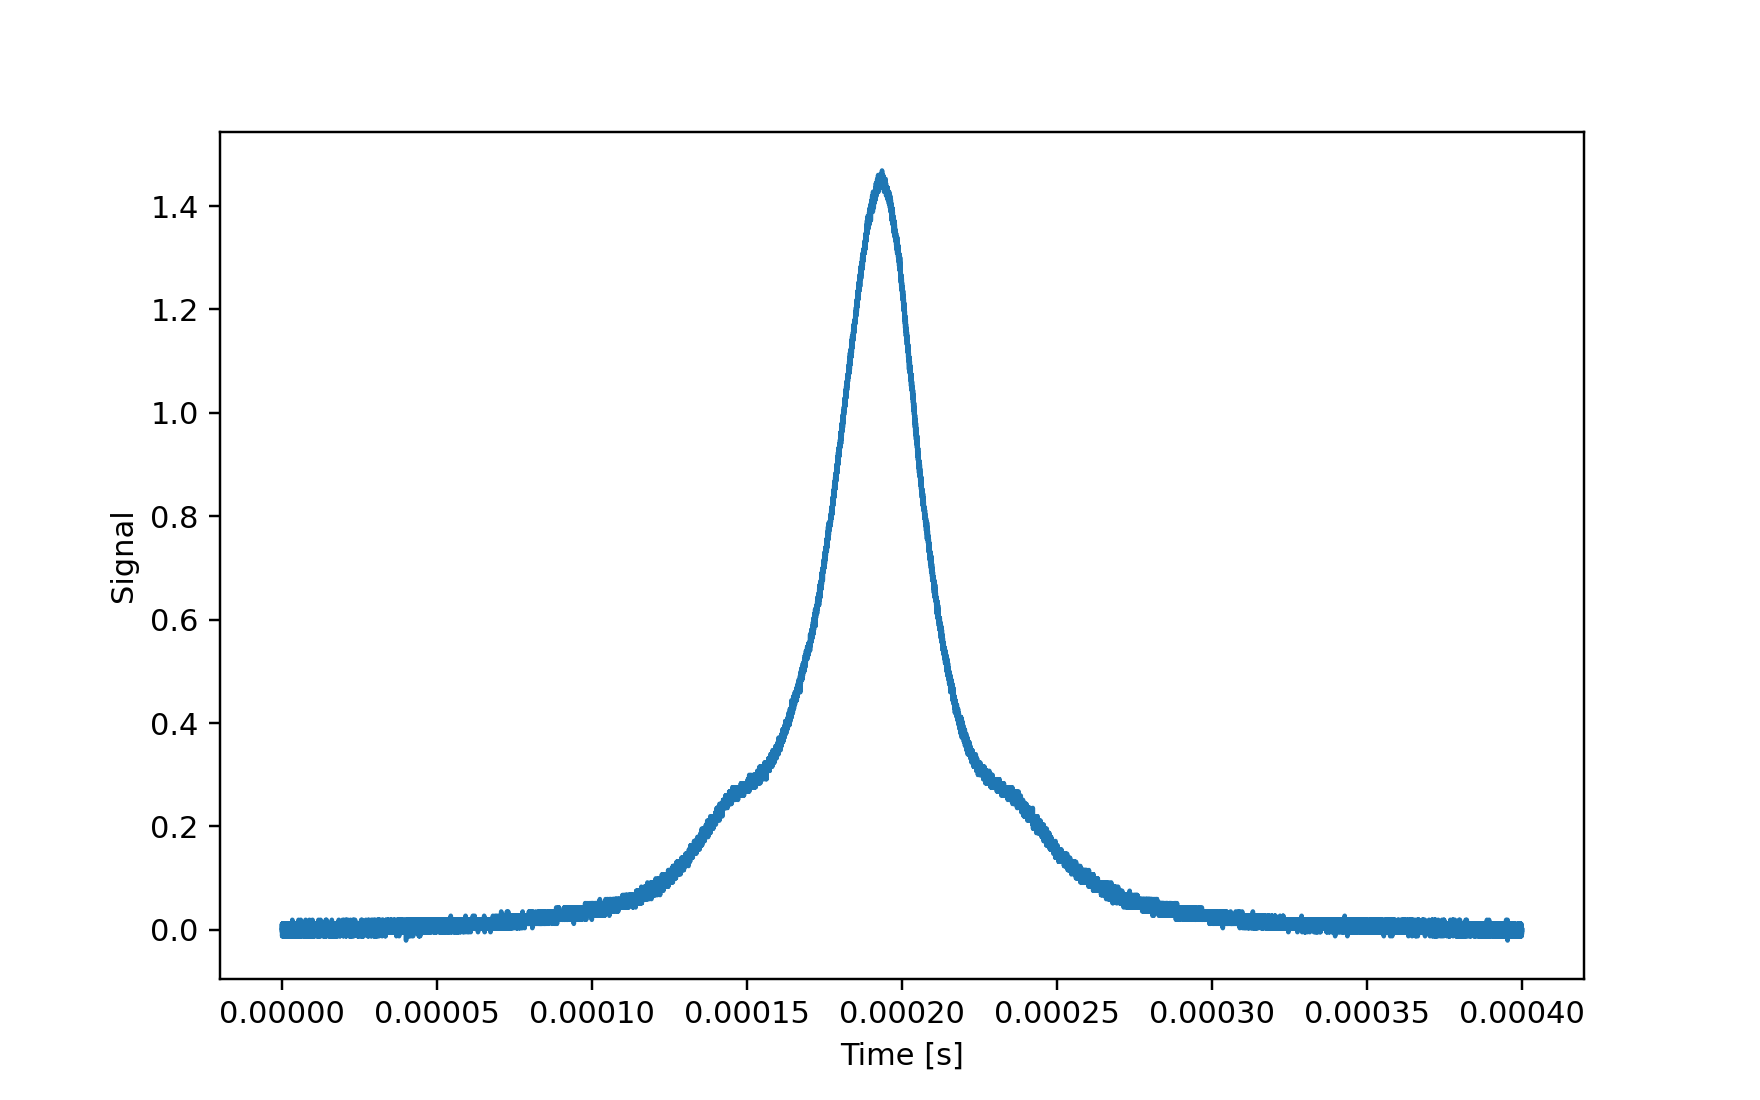

Text(0, 0.5, 'Signal')

In [2]:
#downloading the data
stuff=np.load('mcmc/sidebands.npz')
t=stuff['time']
d=stuff['signal']

#plot the raw data
print('Data size: ',t.size)
plt.figure(figsize=[8,5])
plt.plot(t,d)
plt.xlabel('Time [s]')
plt.ylabel('Signal')


**[a]**

We want to model the data as a single Lorentzian and use analytic derivatives by using Newton's method to carry out the fit.

We assume Gaussian errors so that we can Taylor expand $\chi^2$ to the second order. The idea is to find the global minimum of $\chi^2$ by repeatidly getting closer to it until the changes in $\chi^2$ are small enough. In one dimension, the Newton's method solves for zero of $f(x)$ by taking $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$ (where $n$ is the $n^{th}$ step taken). In multiple dimensions, we want to minimize $\chi^2$ in the parameters space such that we want to set $\nabla \chi^2$ to zero which requires to calculate the gradient and curvature of $\chi^2$. It can be shown that one step of improving the parameters of the model is as follows, with $m_{n+1}$ and $m_n$ being the parameters vectors taken at step $n+1$ and $n$ in parameters space respectively, $A'$ being the gradient matrix where $A'_{i,j}$ is the partial derivative w.r.t. the parameter $j$ and evaluated at the point $i$ and $N$ the noise matrix (which is the Identity if we assume the noise to be gaussian with sigma 1).

$m_{n+1} = m_{n} + (A'^T N^{-1} A')^{-1}(A'^T N^{-1} r)$, where $r=d-A(m_n),$ 

with $A(m_n)$ being the model predictions with the parameters $m_n$ and $d$ the observations such that $r$ is the residuals. We perfom the steps until the difference between the $\chi^2$ of the steps $<<1$ (which means that parameters' likelihood are similar for both steps).

Now, we want to model on a single Lorentzian, we use $d=\frac{a}{1+(t-t_0)^2/w^2}$ and take the analytical partial derivatives w.r.t. $a,t_0$ and $w$ to construct the gradient. Since $a$ is the scale parameter, $t_0$ the shift parameter and $w$ the width parameter, we can make a reasonable guess for the three parameters from the raw figure above and estimate them accordingly. My reasonable guess from the figures were $a=1.4,t_0=0.0002,w=0.00002$.

Number of iteration before satisfying tolerance:  7

Best fit parameters:

a = 1.4228106889886805
t_0 = 0.00019235864947390795
w = 1.7923690583280537e-05


<IPython.core.display.Javascript object>


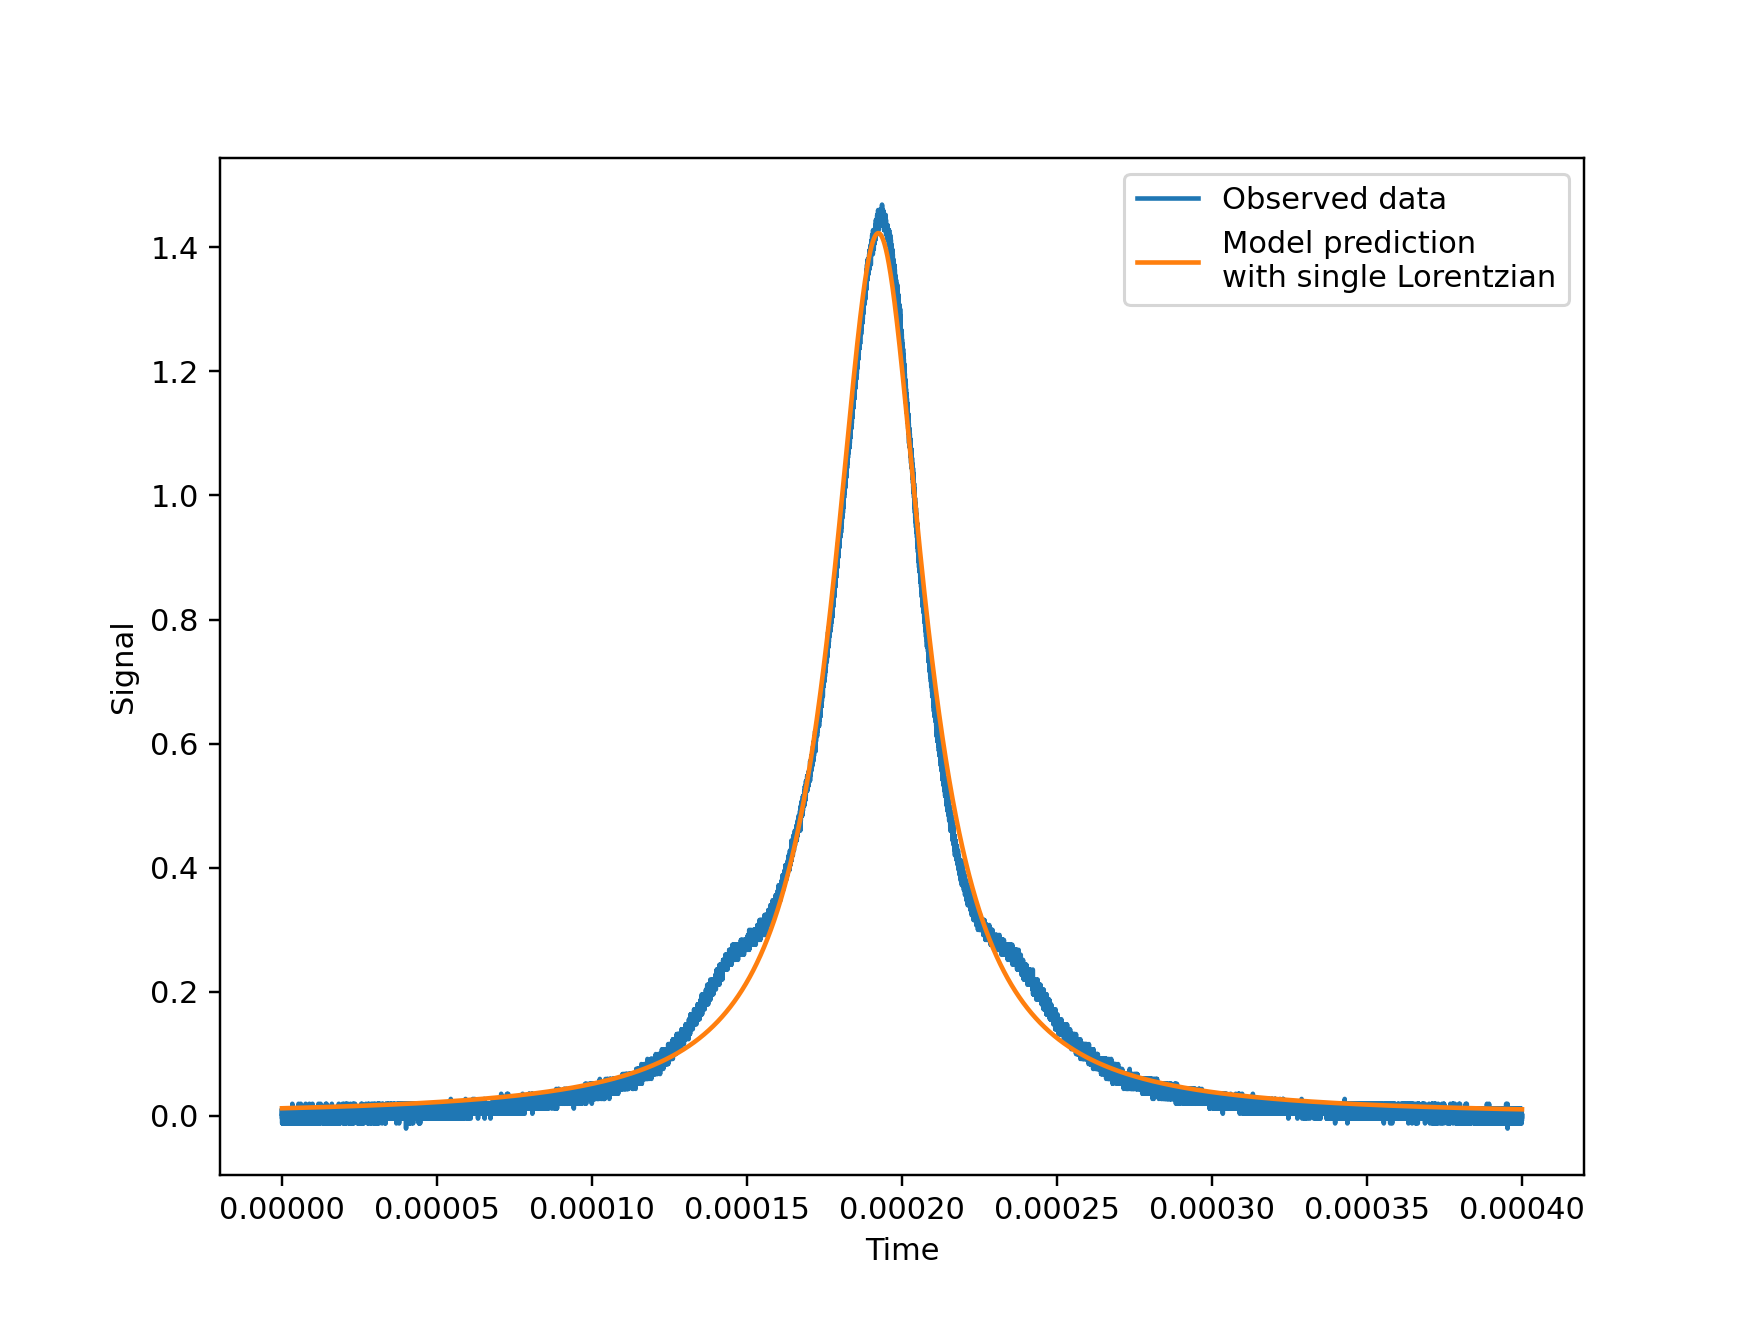

In [3]:
def get_chisq(data,model,sigma=1): #compute 𝜒2, if we assume Gaussian errors then sigma = 1 (and N = Id matrix)
    return np.sum((data-model)**2/sigma**2)

def lorentz_grad(fun,p,t):
    d=fun(p,t)
    
    #differentiate w.r.t. all the parameters (a,t_0,w)
    grad = np.zeros([t.size,p.size])
    grad[:,0] = 1/(1+(t-p[1])**2/(p[2]**2)) #wrt to a
    grad[:,1] = 2*p[0]*p[2]**2*(t-p[1])/(p[2]**2+(t-p[1])**2)**2 #wrt to t_0
    grad[:,2] = 2*p[0]*p[2]*(t-p[1])**2/(p[2]**2+(t-p[1])**2)**2 #wrt to w
    
    return d,grad

def lorentz(p,t):
    return p[0]/(1+(t-p[1])**2/(p[2]**2))

#Newton's Method
def Newtons(fun_model,fun_deriv,tol,p0,t,x):
    p=p0.copy() #the initial parameters vector is the initial guess
    ctn=0 #initialize counter
    pred,grad = fun_deriv(fun_model,p,t) #initial model with the guess parameters
    chi_n = get_chisq(x,pred) #initial 𝜒2 with the guess parameters
    
    while (ctn==0 or abs(chi_n-chi_n1)>tol): #taking the absolute value in case initial guess is bad
        if ctn != 0 :                        #difference should be positive is 𝜒2 is getting better
            chi_n = chi_n1
            
        ctn +=1
        r=x-pred
        err=(r**2).sum()
        r=np.matrix(r).transpose()
        grad=np.matrix(grad)

        lhs=grad.transpose()*grad
        rhs=grad.transpose()*r
        dp=np.linalg.pinv(lhs)*(rhs)

        for n in range(p.size):
            p[n]=p[n]+dp[n] #update parameters by taking the step
        
        pred,grad = fun_deriv(fun_model,p,t)
        chi_n1 = get_chisq(x,pred) #update 𝜒2
    
    print('Number of iteration before satisfying tolerance: ',ctn)
    return p,pred,lhs #return the best-fit parameters and predicted values and lhs for parameter errors estimation
  
p0=np.array([1.4,0.0002,0.00002]) #initial guess for the parameters
tol=1e-8 #such a high tolerance requires very few iterations (7) i.e. Newton's method converges fast
p,pred,lhs = Newtons(lorentz,lorentz_grad,tol,p0,t,d)
print('\nBest fit parameters:\n\na = {}\nt_0 = {}\nw = {}'.format(p[0],p[1],p[2]))

#plot the data and model predictions
plt.figure(figsize=[8,6])
plt.plot(t,d,label='Observed data')
plt.plot(t,pred,label='Model prediction\nwith single Lorentzian')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()


**[b]** Estimating the noise in the data and the errors in the parameters:

We can estimate the noise in the data by taking the mean of the absolute values of the residuals between the modelled predictions (assuming these would be the "true" values) and the observations. We then square them and use them as $\sigma$ on the diagonal $N$ matrix (i.e. noise matrix).

$\sigma = \text{mean}(d_i - \text{pred}_i$) such that $N$ is a diagonal matrix with entries $N_{i,j} = \sigma^2$ for $i=j$. 

Now, because the Taylor expansion is good (as we can tell from the fast convergence of the Newton's method), we can directly conclude the results from linear least squares errors to nonlinear least squares errors. Thus, we have the analogous from linear least square, where the parameters covariance matrix is $(A^{T}N^{-1}A)^{-1}$, that the covariance matrix of the parameters with a nonlinear fit is $(A'^{T}N^{-1}A')^{-1}$. We can use $N$ as the estimated diagonal noise matrix and simply multiply the previously computed $(A'^{T}A')^{-1}$ matrix with $N$, which reduces to simply multiplying by $(A'^{T}A')^{-1}$ the estimation of the noise, squared, i.e. $\sigma^2$. Then, the parameters estimated errors are simply the squareroot of the diagonal entries. 

In [4]:
#take the mean of the absolute value of the residuals to estimate the noise in the data
noise = np.mean(np.abs(pred-d))
param_cov = np.linalg.pinv(lhs)*noise**2
param_err = np.sqrt(np.diag(param_cov))
print('Best fit parameters with their errors:\n')
print('a = {} ± {};\nt_0 = {} ± {};\nw = {} ± {}'.format(f'{p[0]:.6}',f'{param_err[0]:.2}',f'{p[1]:.6}',f'{param_err[1]:.2}',f'{p[2]:.6}',f'{param_err[2]:.2}'))

Best fit parameters with their errors:

a = 1.42281 ± 0.00033;
t_0 = 0.000192359 ± 4.1e-09;
w = 1.79237e-05 ± 5.8e-09


**[c]** Use numerical derivatives instead to compute the gradient

The idea is to compute the $A'$ by taking numerical derivatives instead of analytical derivatives. This is done by calling taking second order numerical derivative with the technique practiced in assignment 1. Here I re-used Jon's code from the mcmc_class.py script, where instead of taking a step dx, we take a step dp for each parameters and evaluate it for each t. Then, we can simply call the Newton's method with the numerical derivatives.

In [5]:
#compute numerical derivatives, re-used code Jon's code
def num_derivs(fun,p,t):
    d=fun(p,t) #model prediction with parameters p
    dp=1e-16**(1/3)*np.abs(p) #this method was used in assignment 1, it is from the textbook p187, 2nd ed.
                                    #we assume that we have no parameters that equal exactly 0
    grad=np.empty([len(t),len(p)]) 
    for i in range(len(p)): #looping of the parameters
        pp=p.copy()
        pp[i]=p[i]+dp[i]
        y_right=fun(pp,t)
        pp[i]=p[i]-dp[i]
        y_left=fun(pp,t)
        grad[:,i]=(y_right-y_left)/(2*dp[i]) #A' computed with numerical derivatives
    
    return d,grad #return the model prediction and A'


Number of iteration before satisfying tolerance:  7

Best fit parameters:

a = 1.422810688986388
t_0 = 0.00019235864947299313
w = 1.792369058333823e-05


<IPython.core.display.Javascript object>


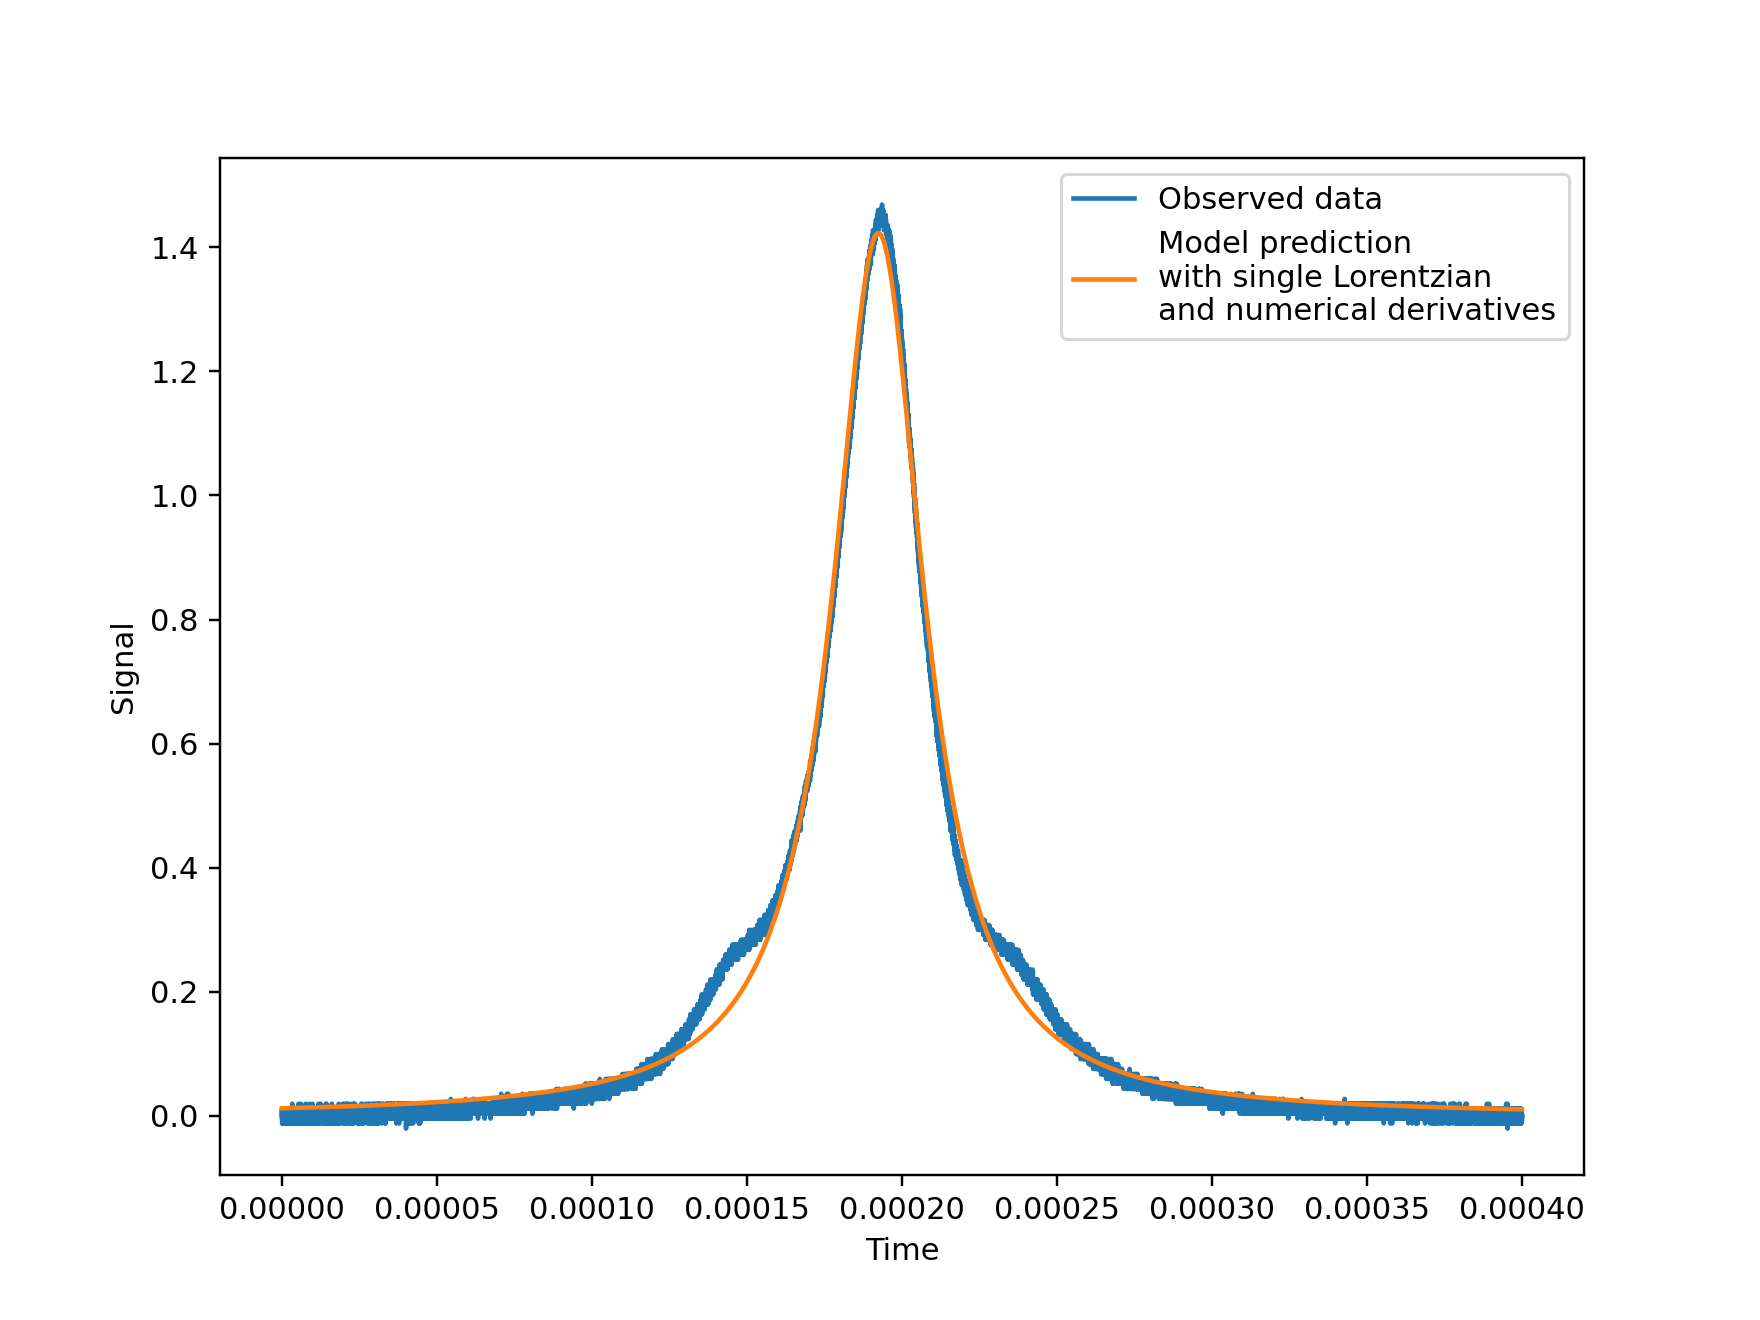

Best fit parameters (with numerical derivatives) with their errors:

a = 1.42281 ± 0.00033;
t_0 = 0.000192359 ± 4.1e-09;
w = 1.79237e-05 ± 5.8e-09


In [6]:
#re-do the fit but with numerical derivatives evaluation
p_num,pred_num,lhs_num = Newtons(lorentz,num_derivs,tol,p0,t,d)
print('\nBest fit parameters:\n\na = {}\nt_0 = {}\nw = {}'.format(p_num[0],p_num[1],p_num[2]))

plt.figure(figsize=[8,6])
plt.plot(t,d,label='Observed data')
plt.plot(t,pred_num,label='Model prediction\nwith single Lorentzian\nand numerical derivatives')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()

#We can also work the errors for the Newton's method with numerical derivatives 
#take the mean of the absolute value of the residuals to estimate the noise in the data
noise_num = np.mean(np.abs(pred_num-d))
param_cov_num = np.linalg.pinv(lhs_num)*noise_num**2
param_err_num = np.sqrt(np.diag(param_cov_num))
print('Best fit parameters (with numerical derivatives) with their errors:\n')
print('a = {} ± {};\nt_0 = {} ± {};\nw = {} ± {}'.format(f'{p_num[0]:.6}',f'{param_err_num[0]:.2}',f'{p_num[1]:.6}',f'{param_err_num[1]:.2}',f'{p_num[2]:.6}',f'{param_err_num[2]:.2}'))


In [7]:
#Let's investigate statistical difference between using the numerical derivatives and analytical derivatives
pars_diff = p-p_num
print('Difference in parameter a is {}, t_0 is {} and w is {}'.format(f'{pars_diff[0]:.3}',f'{pars_diff[1]:.3}',f'{pars_diff[2]:.3}'))
print('Where we can say that it is numerically 0 for parameters t_0 and w\n')

chisq_ana = get_chisq(d,pred,noise)
chisq_num = get_chisq(d,pred_num,noise_num)
chisq_diff = chisq_ana-chisq_num
print('The difference of χ2 between analytical and numerical methods is',chisq_diff)
print('In other words, we can say that the χ2 are "computationally" the same.\n')

print('The estimated noise for the analytical and numerical derivatives methods is {} and {} respectively.\n'.format(noise,noise_num))

print('I think we can safely say that the answers are statistically the same (i.e. no significant differences) given that they return similar parameters, χ2 and noise estimations!')

Difference in parameter a is 2.29e-12, t_0 is 9.15e-16 and w is -5.77e-17
Where we can say that it is numerically 0 for parameters t_0 and w

The difference of χ2 between analytical and numerical methods is 1.6500300262123346e-05
In other words, we can say that the χ2 are "computationally" the same.

The estimated noise for the analytical and numerical derivatives methods is 0.019352836173204296 and 0.019352836174143462 respectively.

I think we can safely say that the answers are statistically the same (i.e. no significant differences) given that they return similar parameters, χ2 and noise estimations!


**[d]** Model as the sum of three Lorentzian

The idea is to repeat the same methods described above, given the "new" function which is the sum of three gaussians. Again, the starting parameters were guessed visually from the graph for the 3 new parameters, and the fitted parameters from above were used for the other 3 parameters.

Number of iteration before satisfying tolerance:  8


<IPython.core.display.Javascript object>


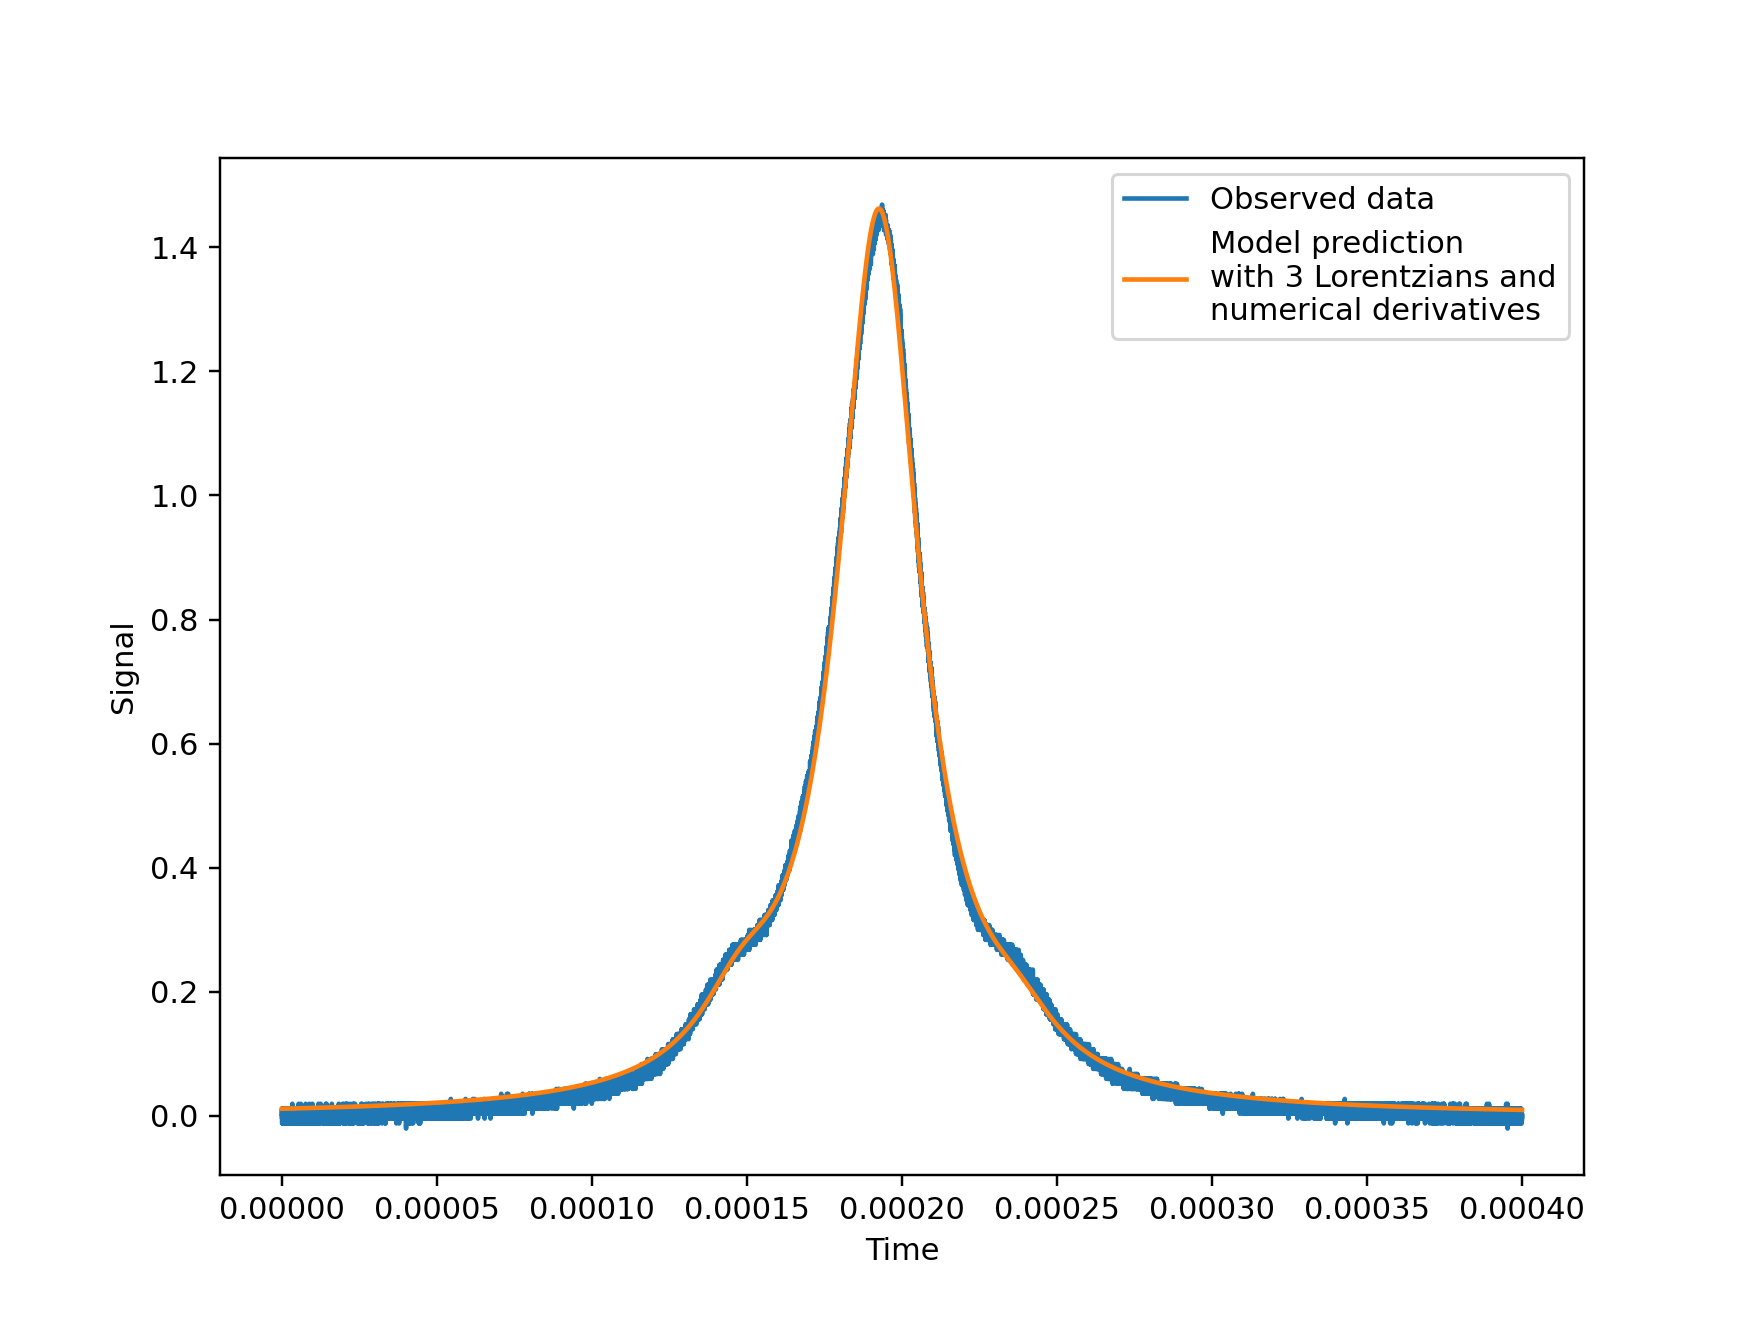

In [8]:
def lorentz_3(p,t):
    return p[0]/(1+(t-p[1])**2/(p[2]**2)) + p[3]/(1+(t-p[1]+p[4])**2/(p[2]**2)) + p[5]/(1+(t-p[1]-p[4])**2/(p[2]**2))

p0=np.array([p_num[0],p_num[1],p_num[2],0.2,0.00004,0.2])
tol=1e-08
p_num3,pred_num3,lhs3 = Newtons(lorentz_3,num_derivs,tol,p0,t,d)

plt.figure(figsize=[8,6])
plt.plot(t,d,label='Observed data')
plt.plot(t,pred_num3,label='Model prediction\nwith 3 Lorentzians and\nnumerical derivatives')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()

Errors on the parameters, same method as described above

In [9]:
#take the mean of the absolute value of the residuals to estimate the noise in the data
noise_num3 = np.mean(np.abs(pred_num3-d))
param_cov3 = np.linalg.pinv(lhs3)*noise_num3**2
param_err_num3 = np.sqrt(np.diag(param_cov3))
print('Best fit parameters with 3 Lorentzians and numerical derivatives:\n')
print('a = {} ± {};\nb = {} ± {};\nc = {} ± {};\nt_0 = {} ± {};\ndt = {} ± {};\nw = {} ± {}'
                                                 .format(f'{p_num3[0]:.6}',f'{param_err_num3[0]:.2}',
                                                         f'{p_num3[3]:.6}',f'{param_err_num3[3]:.2}',
                                                         f'{p_num3[5]:.6}',f'{param_err_num3[5]:.2}',
                                                         f'{p_num3[1]:.6}',f'{param_err_num3[1]:.2}',
                                                         f'{p_num3[4]:.6}',f'{param_err_num3[4]:.2}',
                                                         f'{p_num3[2]:.6}',f'{param_err_num3[2]:.2}'))

Best fit parameters with 3 Lorentzians and numerical derivatives:

a = 1.44299 ± 0.00023;
b = 0.103911 ± 0.00022;
c = 0.0647324 ± 0.00022;
t_0 = 0.000192579 ± 2.7e-09;
dt = 4.45672e-05 ± 3.3e-08;
w = 1.60651e-05 ± 4.9e-09


**[e]** Plotting the residuals

We can very noticably observe structure in the residuals suggesting that the assumption that the data are independent with uniform variance is wrong. Indeed, the model does not give a complete description of the data.


<IPython.core.display.Javascript object>


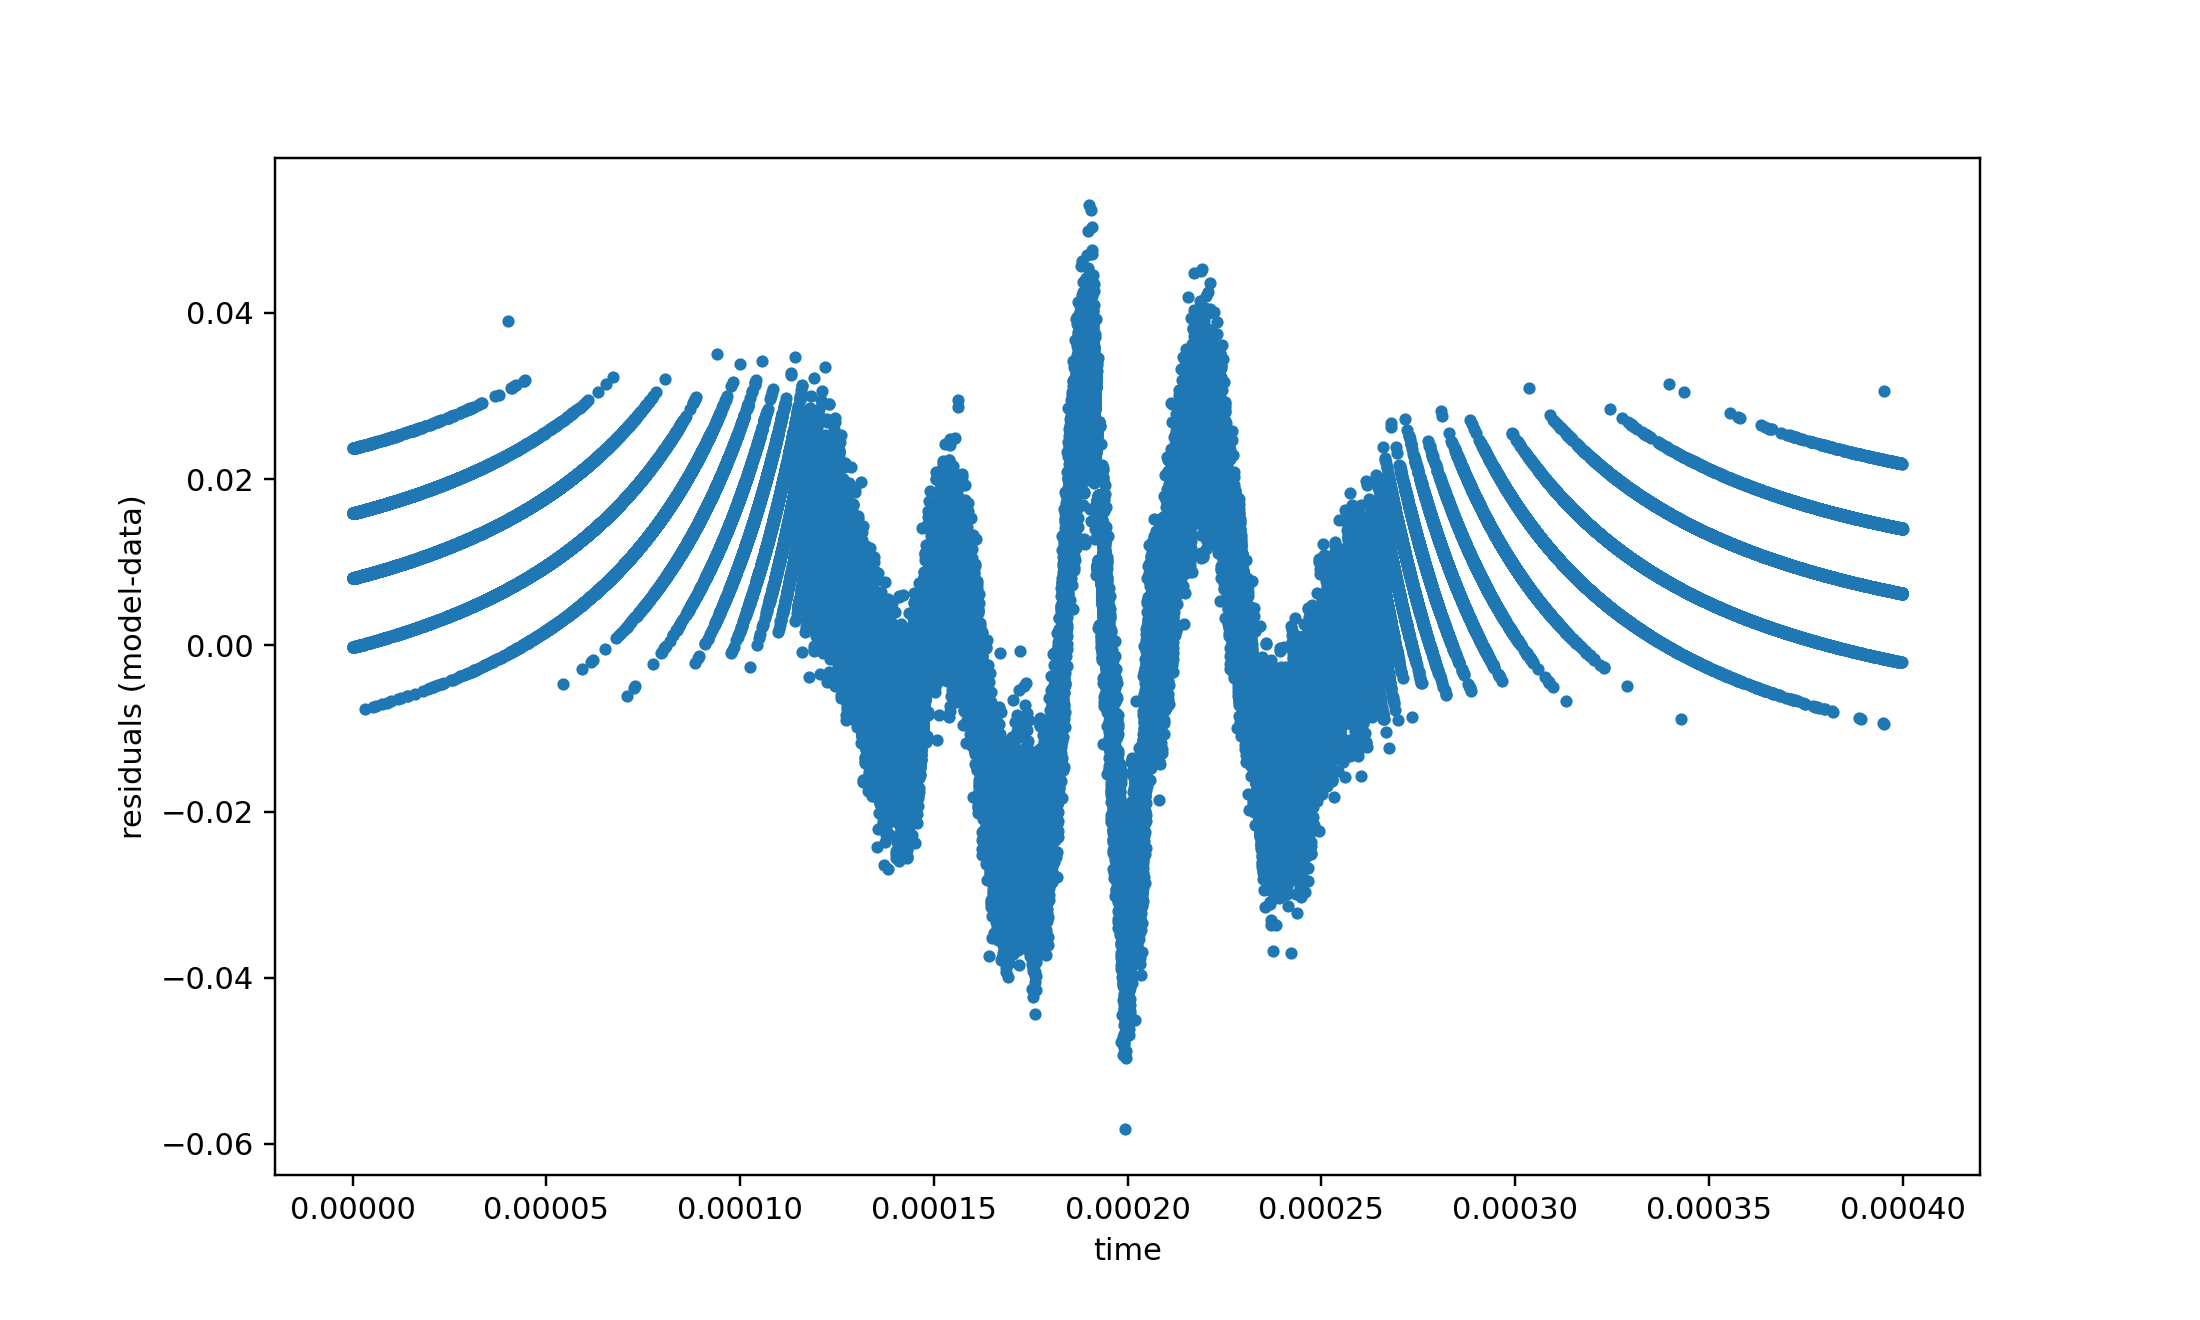

Text(0, 0.5, 'residuals (model-data)')

In [10]:
res_num3 = pred_num3 - d

print('We can very noticably observe structure in the residuals suggesting that the assumption that the data are independent with uniform variance is wrong. Indeed, the model does not give a complete description of the data.')

plt.figure(figsize=[10,6])
plt.plot(t,res_num3,'.')
plt.xlabel('time')
plt.ylabel('residuals (model-data)')

**[f]** Generating realizations:

Here, we use the estimation of the parameters and the parameters covariance obtained from the noise estimation and Newton's method to obtain new parameters (i.e. realizations). The covariance matrix gives estimates of how two variables (here parameters) vary together and the parameters are used as the locations where samples are most likely to be found. Then, we can use these to draw samples from a multivariable normal distribution (where the distribution is given by the parameters and the parameters covariance matrix). I use the function *np.random.multivariate_normal* as suggested by Rigel to perform this.

<IPython.core.display.Javascript object>


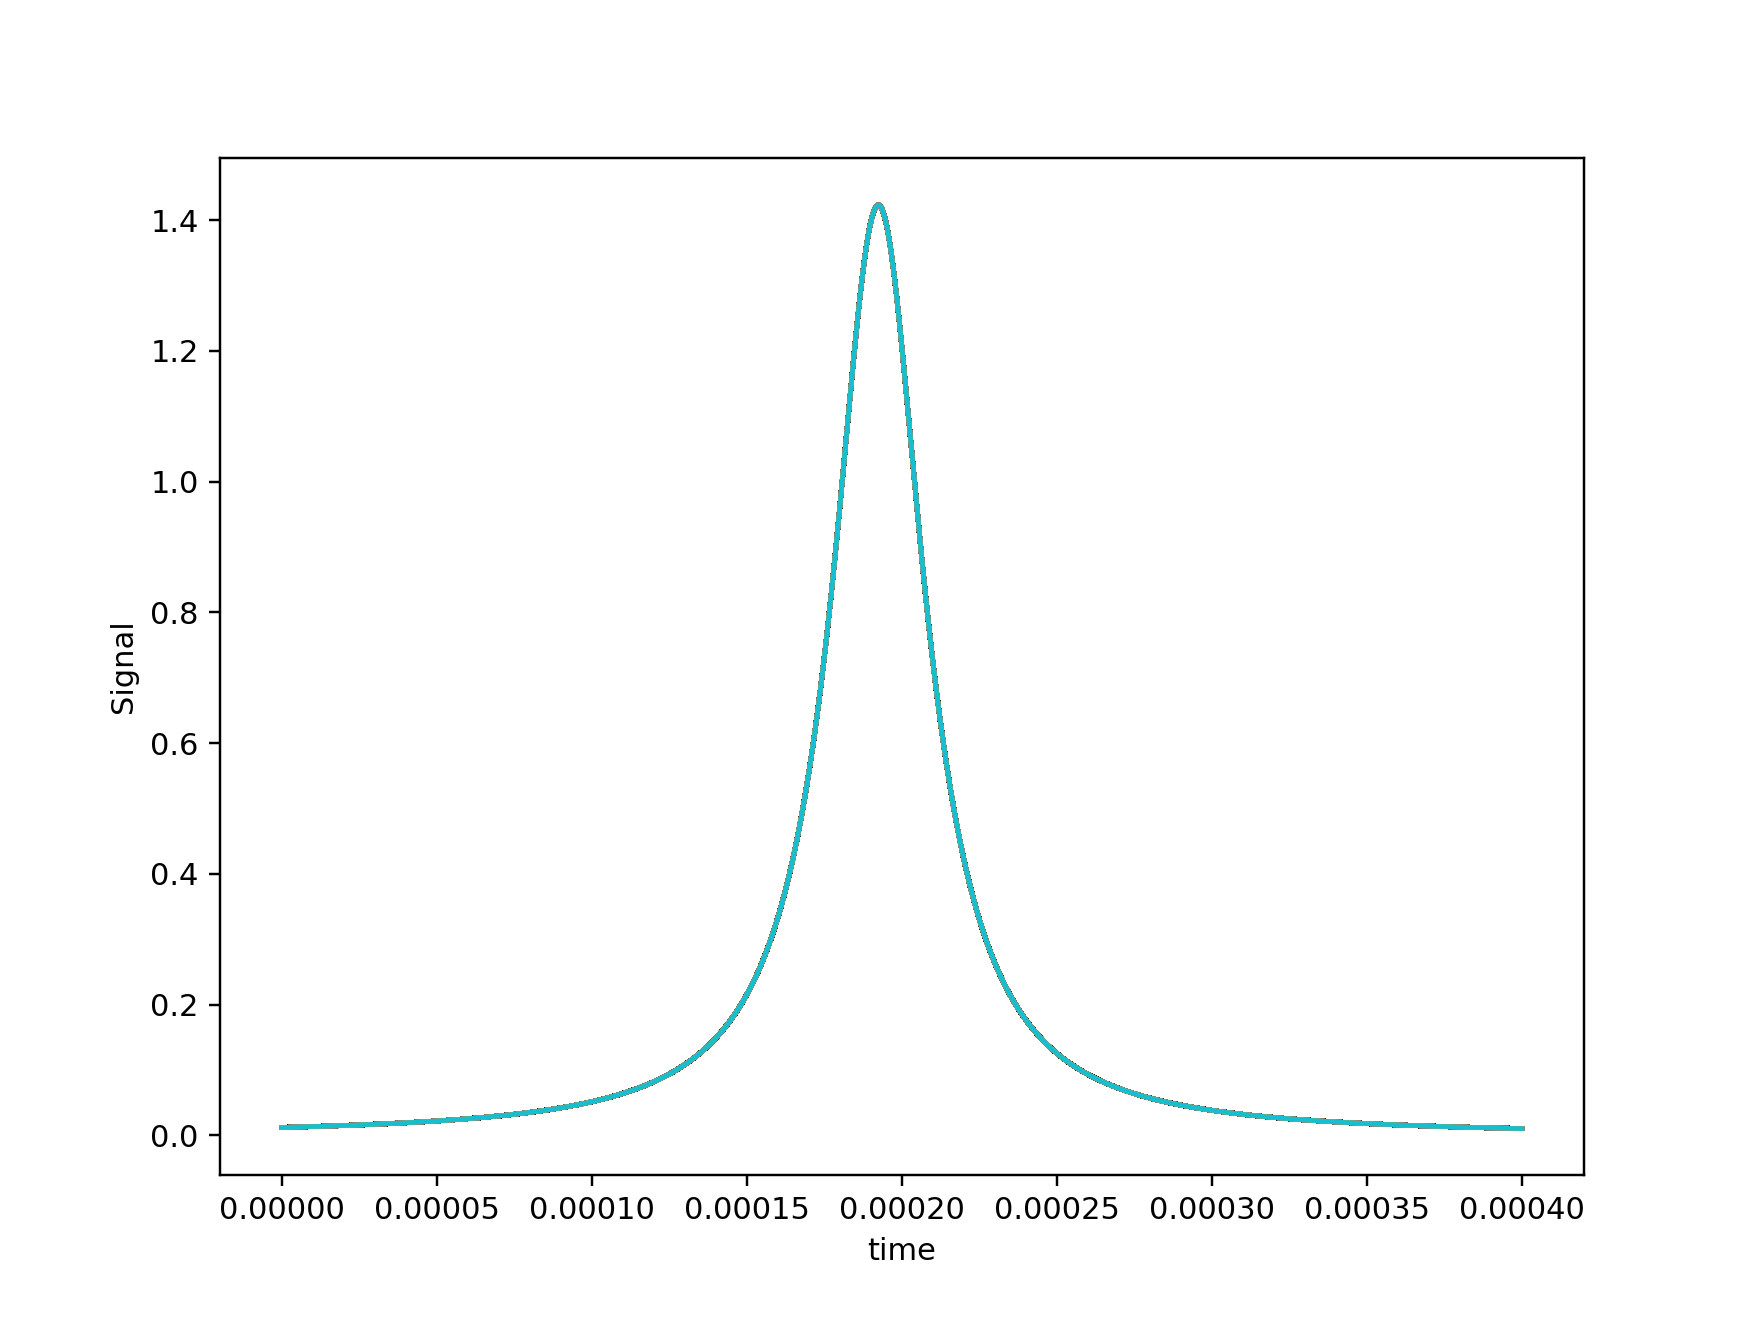

Parameters from the 1000 realizations, mean and std

a = 1.423 ± 0.00034;
t_0 = 0.000192359 ± 4.1e-09;
w = 1.79238e-05 ± 5.8e-09


Computed 𝜒2 from our best fit parameters:  170005.81193234838
Mean difference of the 𝜒2 with the parameters realization and the best fit:  3.0242988994927438


In [11]:
#generate realizations for the 3 parameters Lorentzian
n_realiz = 1000 #number of realizations we want to perform
realiz = np.random.multivariate_normal(p_num,param_cov,n_realiz) 
chisq = np.zeros(n_realiz)
chisq_bestfit = get_chisq(d,lorentz(p_num,t),noise)

plt.figure(figsize=[8,6])
cnt=0
for params in realiz:
    model = lorentz(params,t)
    chisq[cnt] = get_chisq(d,model,noise)
    cnt += 1
    plt.plot(t,model) #plot each realizations
plt.xlabel('time')
plt.ylabel('Signal')

var_realiz = np.std(realiz,axis=0)
mean_realiz = np.mean(realiz,axis=0)
mean_diff = np.mean(np.abs(chisq-chisq_bestfit))

print('Parameters from the {} realizations, mean and std\n'.format(n_realiz))
print('a = {} ± {};\nt_0 = {} ± {};\nw = {} ± {}'
                                                 .format(f'{mean_realiz[0]:.4}',f'{var_realiz[0]:.2}',
                                                         f'{mean_realiz[1]:.6}',f'{var_realiz[1]:.2}',
                                                         f'{mean_realiz[2]:.6}',f'{var_realiz[2]:.2}'))

print('\n\nComputed 𝜒2 from our best fit parameters: ',chisq_bestfit)
print('Mean difference of the 𝜒2 with the parameters realization and the best fit: ',mean_diff)


<IPython.core.display.Javascript object>


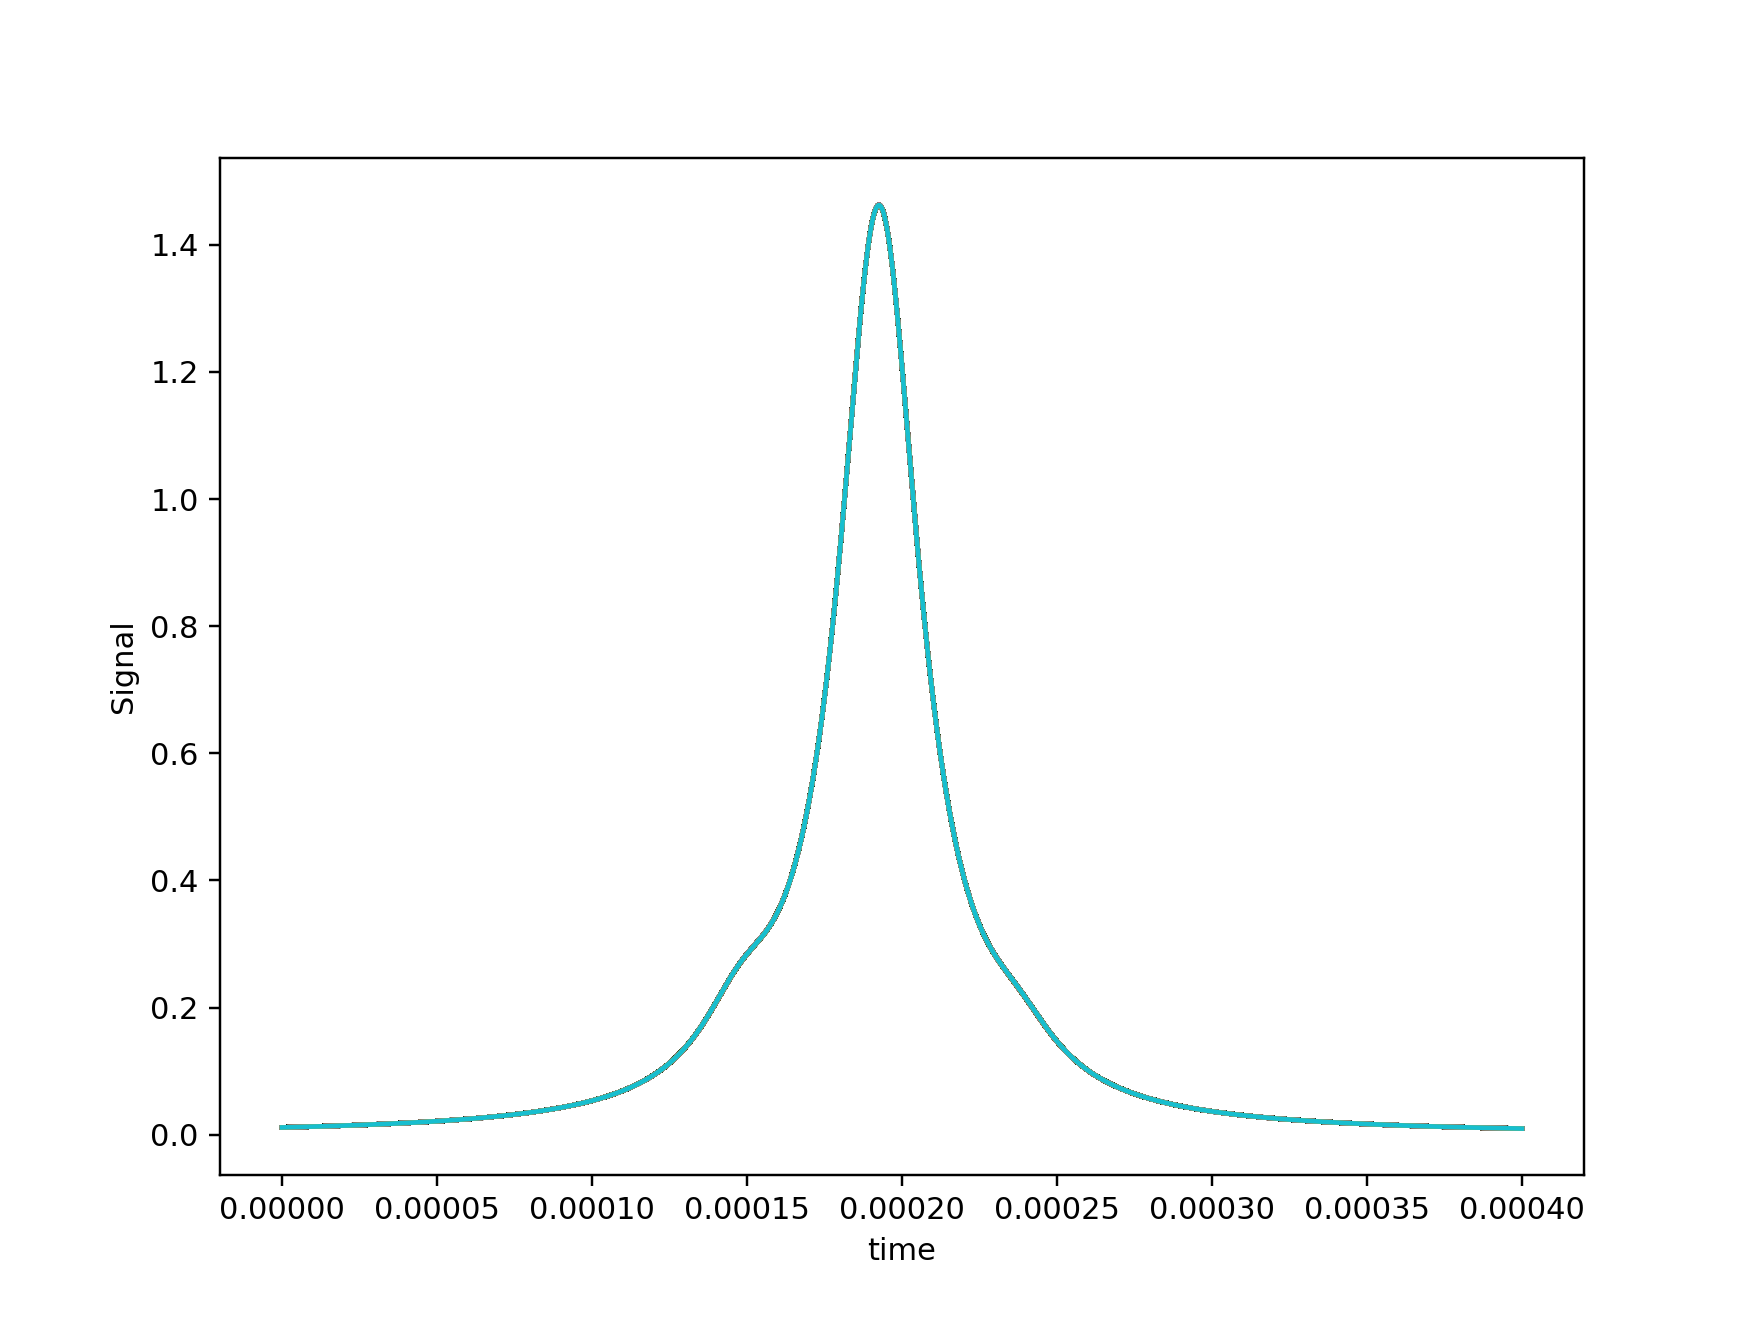

Parameters from the 1000 realizations, mean and std

a = 1.443 ± 0.00023;
b = 0.103902 ± 0.00022;
c = 0.0647285 ± 0.00021;
t_0 = 0.000192579 ± 2.7e-09;
dt = 4.45677e-05 ± 3.4e-08;
w = 1.60654e-05 ± 4.9e-09


Computed 𝜒2 from our best fit parameters:  133698.27274077304
Mean difference of the 𝜒2 with the parameters realization and the best fit:  6.186437878815864
This mean difference corresponds to 0.00463% of the 𝜒2 value with best fit parameters!


In [12]:
#generate realizations for the 6 parameters 3-Lorentzian
n_realiz = 1000 #number of realizations we want to perform
realiz = np.random.multivariate_normal(p_num3,param_cov3,n_realiz) 
chisq = np.zeros(n_realiz)
chisq_bestfit = get_chisq(d,lorentz_3(p_num3,t),noise_num3)

plt.figure(figsize=[8,6])
cnt=0
for params in realiz:
    model = lorentz_3(params,t)
    chisq[cnt] = get_chisq(d,model,noise_num3)
    cnt += 1
    plt.plot(t,model) #plot each realizations
plt.xlabel('time')
plt.ylabel('Signal')

var_realiz = np.std(realiz,axis=0)
mean_realiz = np.mean(realiz,axis=0)
mean_diff = np.mean(np.abs(chisq-chisq_bestfit))

print('Parameters from the {} realizations, mean and std\n'.format(n_realiz))
print('a = {} ± {};\nb = {} ± {};\nc = {} ± {};\nt_0 = {} ± {};\ndt = {} ± {};\nw = {} ± {}'
                                                 .format(f'{mean_realiz[0]:.4}',f'{var_realiz[0]:.2}',
                                                         f'{mean_realiz[3]:.6}',f'{var_realiz[3]:.2}',
                                                         f'{mean_realiz[5]:.6}',f'{var_realiz[5]:.2}',
                                                         f'{mean_realiz[1]:.6}',f'{var_realiz[1]:.2}',
                                                         f'{mean_realiz[4]:.6}',f'{var_realiz[4]:.2}',
                                                         f'{mean_realiz[2]:.6}',f'{var_realiz[2]:.2}'))

print('\n\nComputed 𝜒2 from our best fit parameters: ',chisq_bestfit)
print('Mean difference of the 𝜒2 with the parameters realization and the best fit: ',mean_diff)
print('This mean difference corresponds to {}% of the 𝜒2 value with best fit parameters!'.format(f'{mean_diff/chisq_bestfit*100:.3}'))


We observe that for both Lorentzian, the plotted models are all similar from one another. When we zoom in, we can observe small shifts between the models which is expected as we "pertube" the parameters.

For 1-d standard normal distribution realizations, we expect the mean difference in the 𝜒2 of realizations to be of one sigma, or 1 if we assume uniform variance as we draw samples from one parameter (i.e. "pertube" the parameter w.r.t. to its own variance). We could assume that if we expand this to n-d multivariable normal distribution of realizations, we would expect the mean difference between the 𝜒2 to be of n-sigma (or n). Thus, it makes sense that for the 3-Lorentz model (i.e. 6 parameters) we have a mean difference close to 6 and similarly for the Lorentz model (i.e. 3 parameters) we have a mean difference close to 3. 

**[g]** Redo the fit using MCMC

The idea of the MCMC chain is to "trace" the distribution of the model parameters (thereby the likelihood surface) to eventually converge to the best-fit parameters model. To converge faster, we can optimize the method of choosing the step size and direction (in the parameters space). To do that, we use the covariance matrix obtained from Newton's method as a way to take into account the correlation of the parameters when a step is taken. Computationally, we can use *np.random.multivariate_normal* centered at 0 with the covariance matrix given by Newton's method as the distribution parameters. This will return a vector of "intelligent" shifts for each parameters, Then, the 𝜒2 is computed at each new step of the Markov Chain to compute the probability of taking the step which is proportional to the ratio of the likelihood i.e. $p = \text{e}^{\Delta \chi^2 /2}$. If the $p$ is greater than a random number between 0 and 1, then we take the step and continue from there; if not, we "stay" at the same location and choose another step. We want to accept about 25% of the steps in our samples to have enough freedom to go "outside" of the optimal path and "explore" for other likelihood minima. We can add a scaling parameter when we calculate the new steps to aim for that ideal ratio of step acceptance.

In [13]:
#I used Jon's code and redapted it a little bit
def get_step(step_size,cov):
    return np.random.multivariate_normal(np.zeros(cov[0].size),cov)*step_size #step size is the scaling parameter   

def run_mcmc(fun,pars,step_scale,cov,noise,data,t_data,nstep=2000,T=1): #T can be used as an overall scaling
    acc=0 #number of steps accepted (i.e. p > random number between 0 and 1)
    npar=len(pars)
    chain=np.zeros([nstep,npar]) #matrix of the parameters
    chisq=np.zeros(nstep) #vector of the 𝜒2
    chain[0,:]=pars #first location is the guess parameters
    chi_cur=get_chisq(data,fun(pars,t_data),noise) #compute the chi square
    chisq[0]=chi_cur
    for i in tqdm(range(1,nstep)): #will stop when the number of steps will be reached
        pp=pars+get_step(step_scale,cov) #take a trial step
        new_chisq=get_chisq(data,fun(pp,t_data),noise) #compute new chi square
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T) #compute prob 
        if np.random.rand(1)<accept_prob: #step is accepted if True
            pars=pp 
            chi_cur=new_chisq
            acc += 1 #updated the number of accepted parameters
        chain[i,:]=pars
        chisq[i]=chi_cur
    print('The ratio of accepted steps is {}.'.format(f'{acc/nstep:.2}'))
    return chain,chisq  #return the chain of the parameters and the Chi-Square



In [14]:
#parameters for the mcmc chain
pars = p_num3.copy()
trialstp=1 #scale to optimize the acceptance ratio
cov=param_cov3
nstep=100000
scaling=1

start = time.time()
chain,chisq = run_mcmc(lorentz_3,pars,trialstp,cov,noise_num3,d,t,nstep,scaling)
end = time.time()
print('Time it took to do the {} steps of the MCMC chain is {}s'.format(nstep,f'{end-start:.2}'))

  0%|          | 0/99999 [00:00<?, ?it/s]

The ratio of accepted steps is 0.26.
Time it took to do the 100000 steps of the MCMC chain is 7.9e+01s


<IPython.core.display.Javascript object>


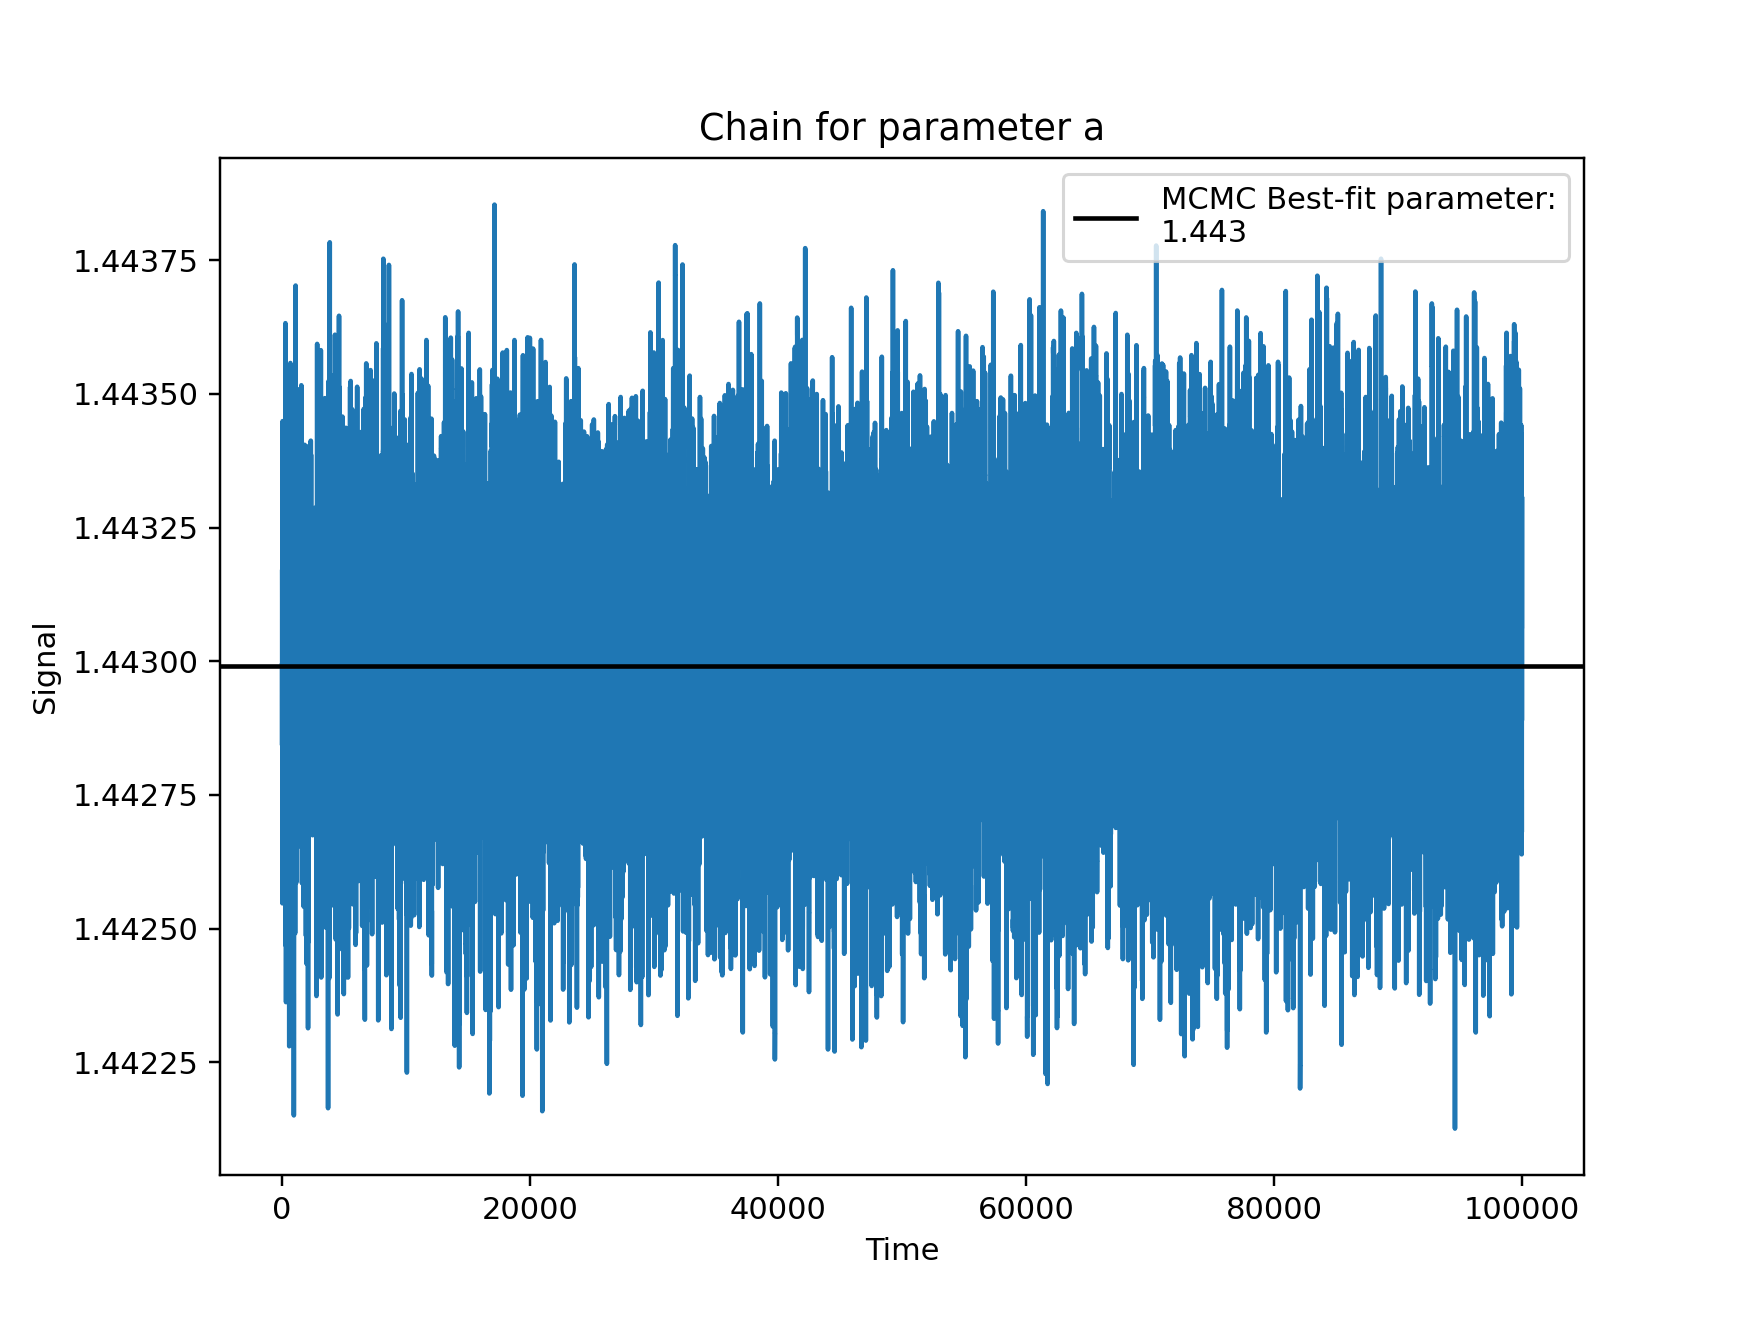

<IPython.core.display.Javascript object>


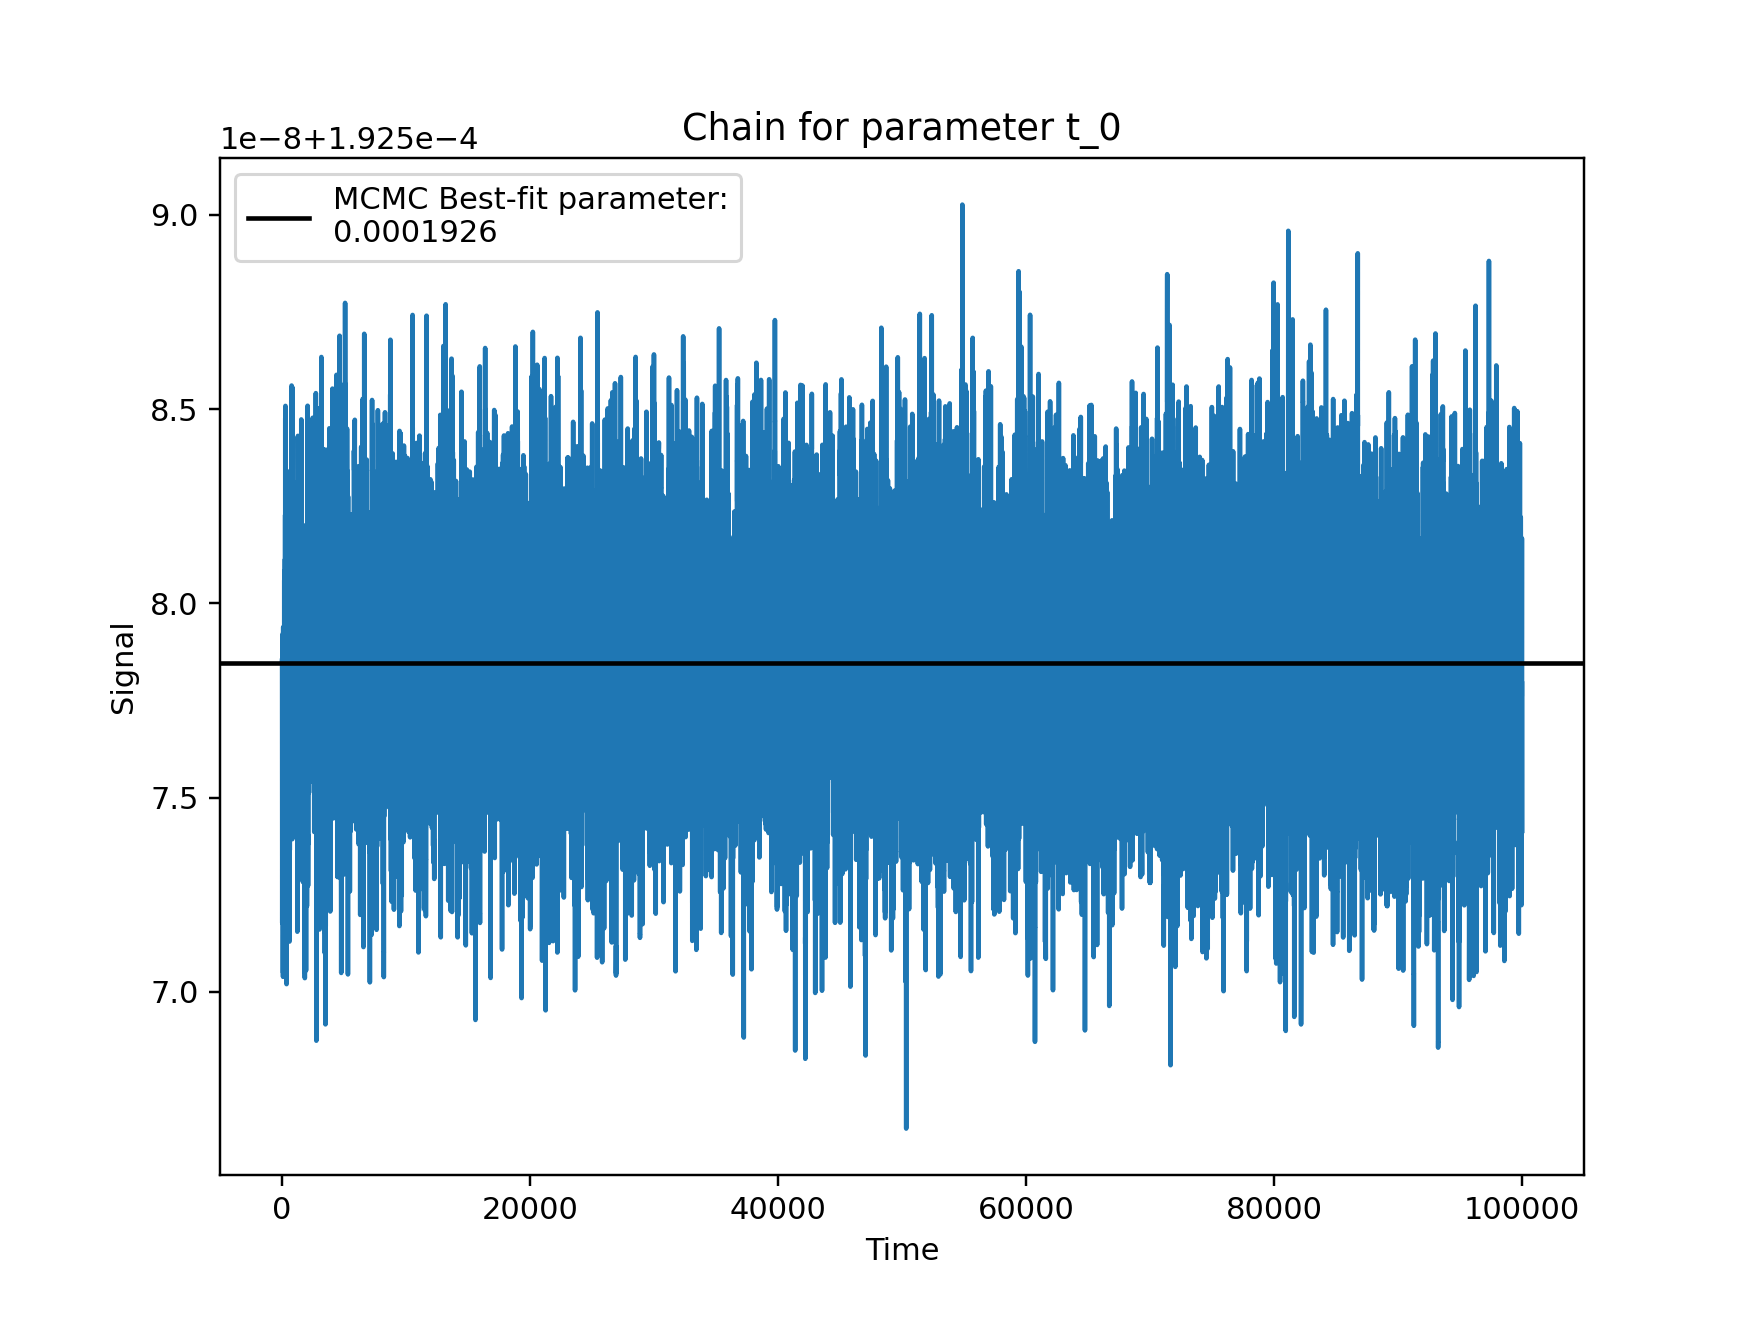

<IPython.core.display.Javascript object>


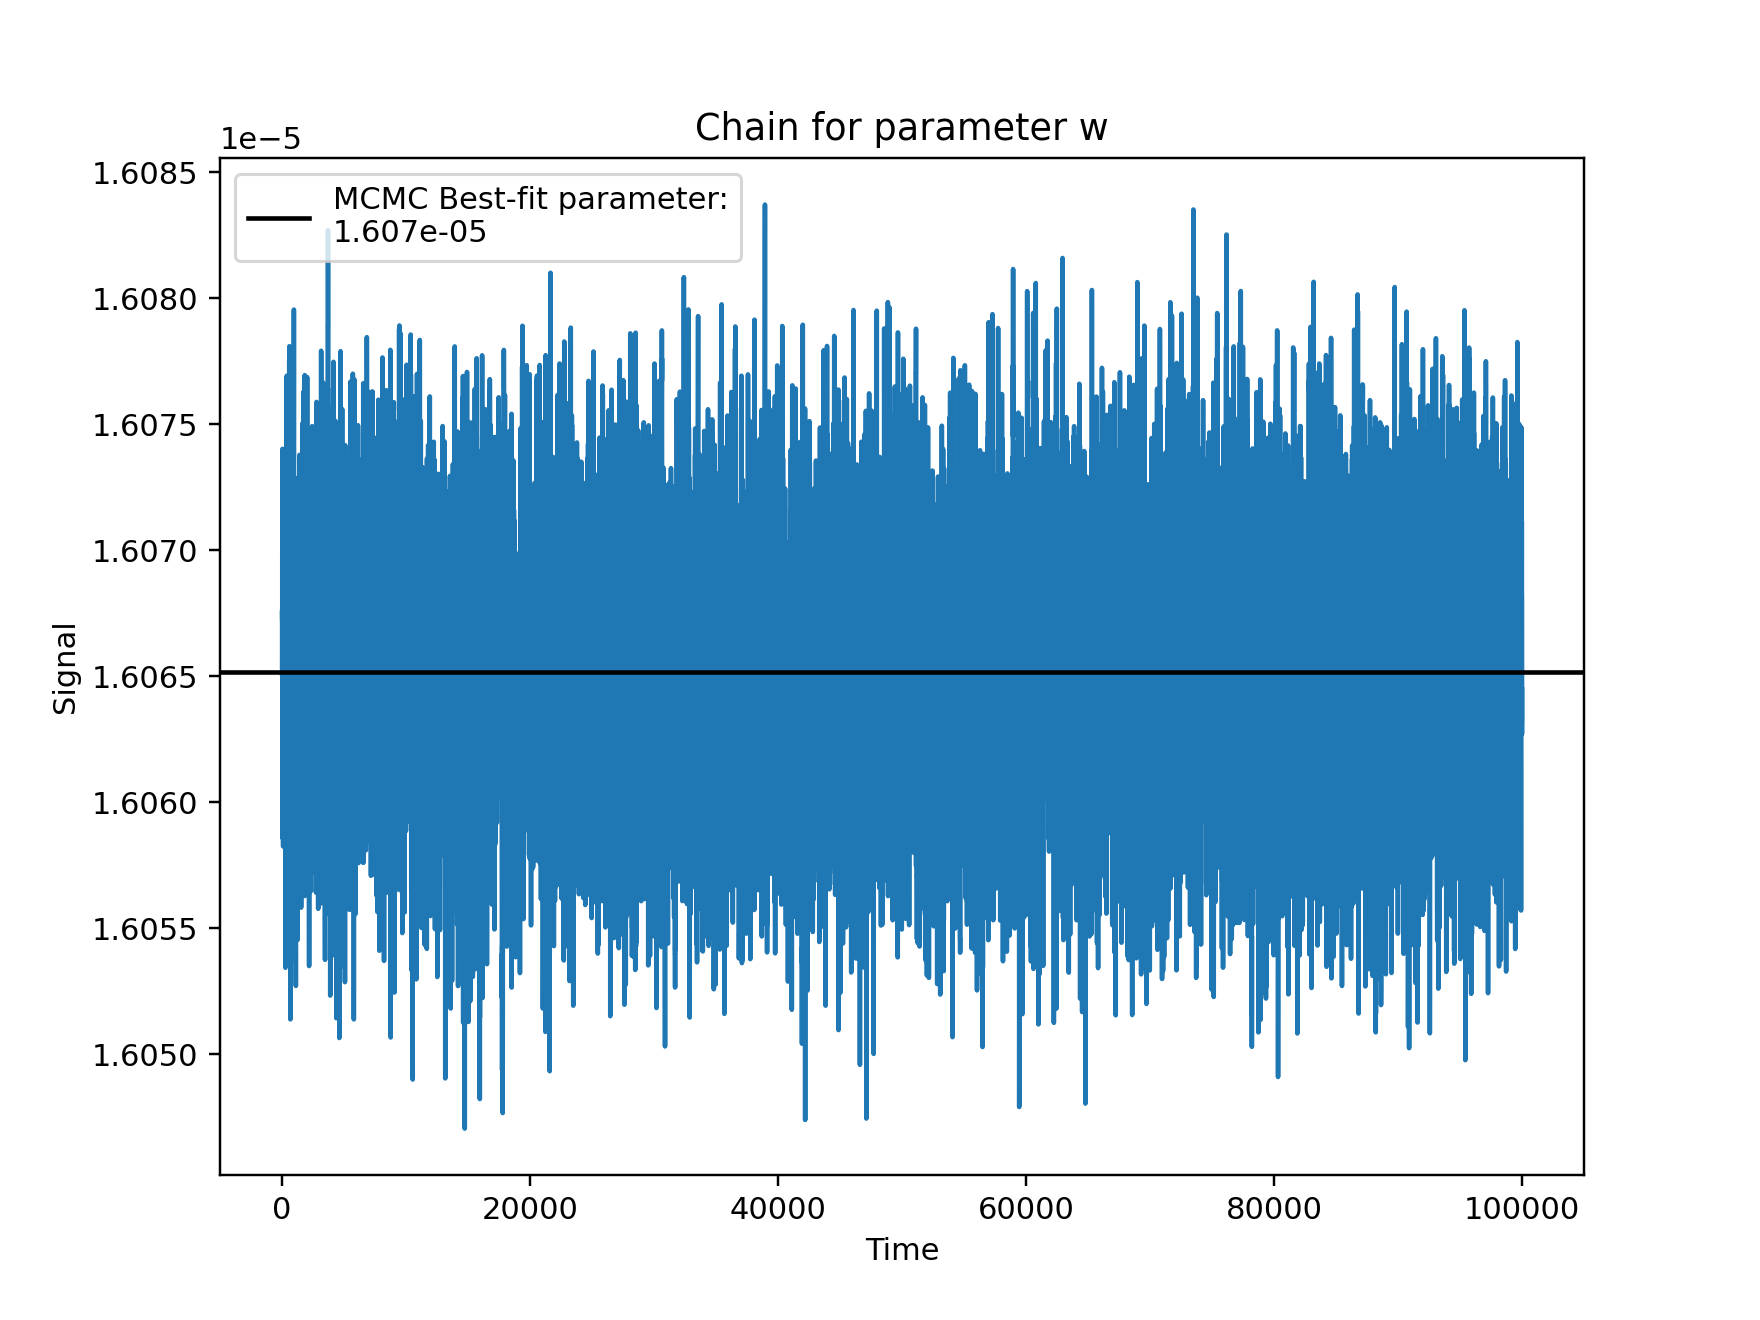

<IPython.core.display.Javascript object>


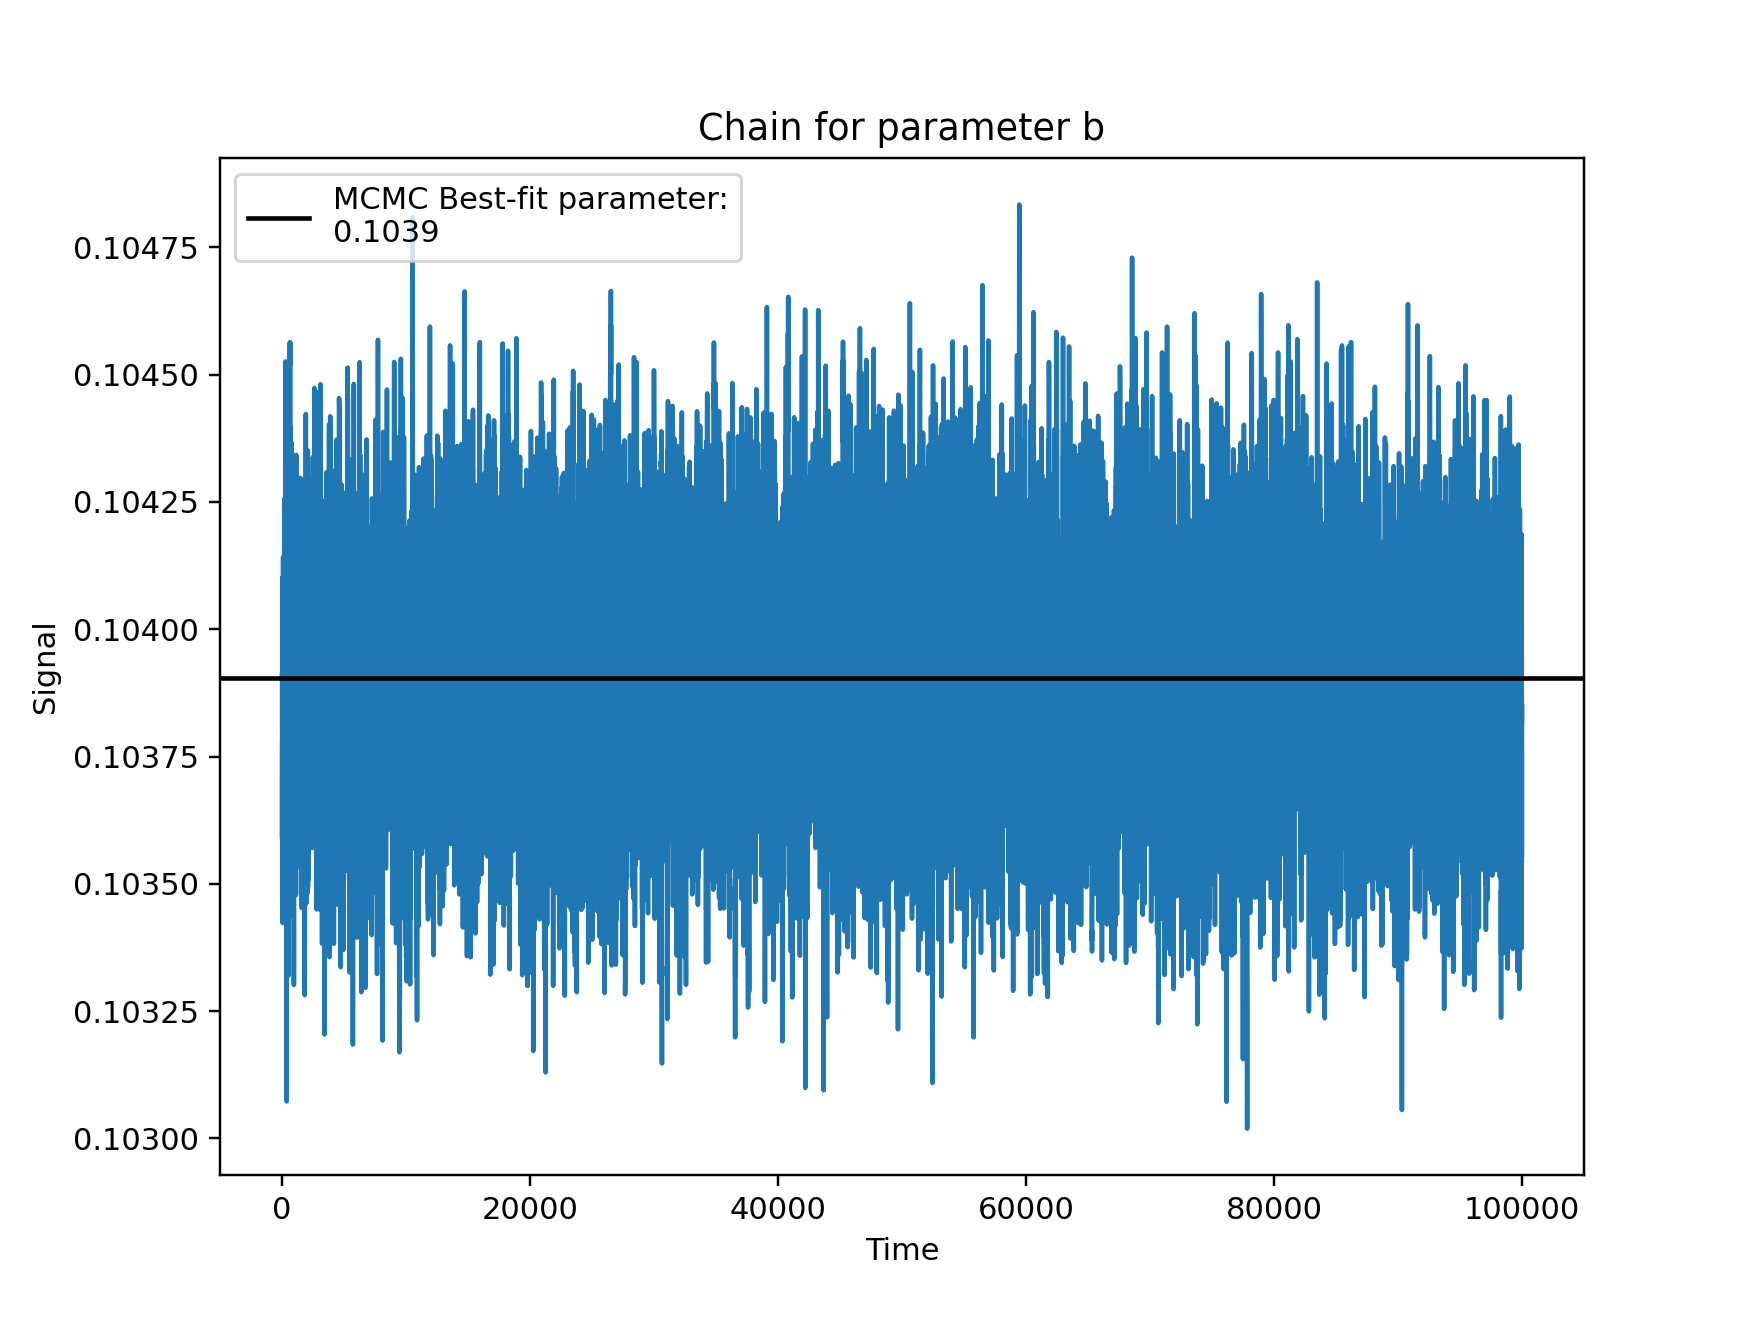

<IPython.core.display.Javascript object>


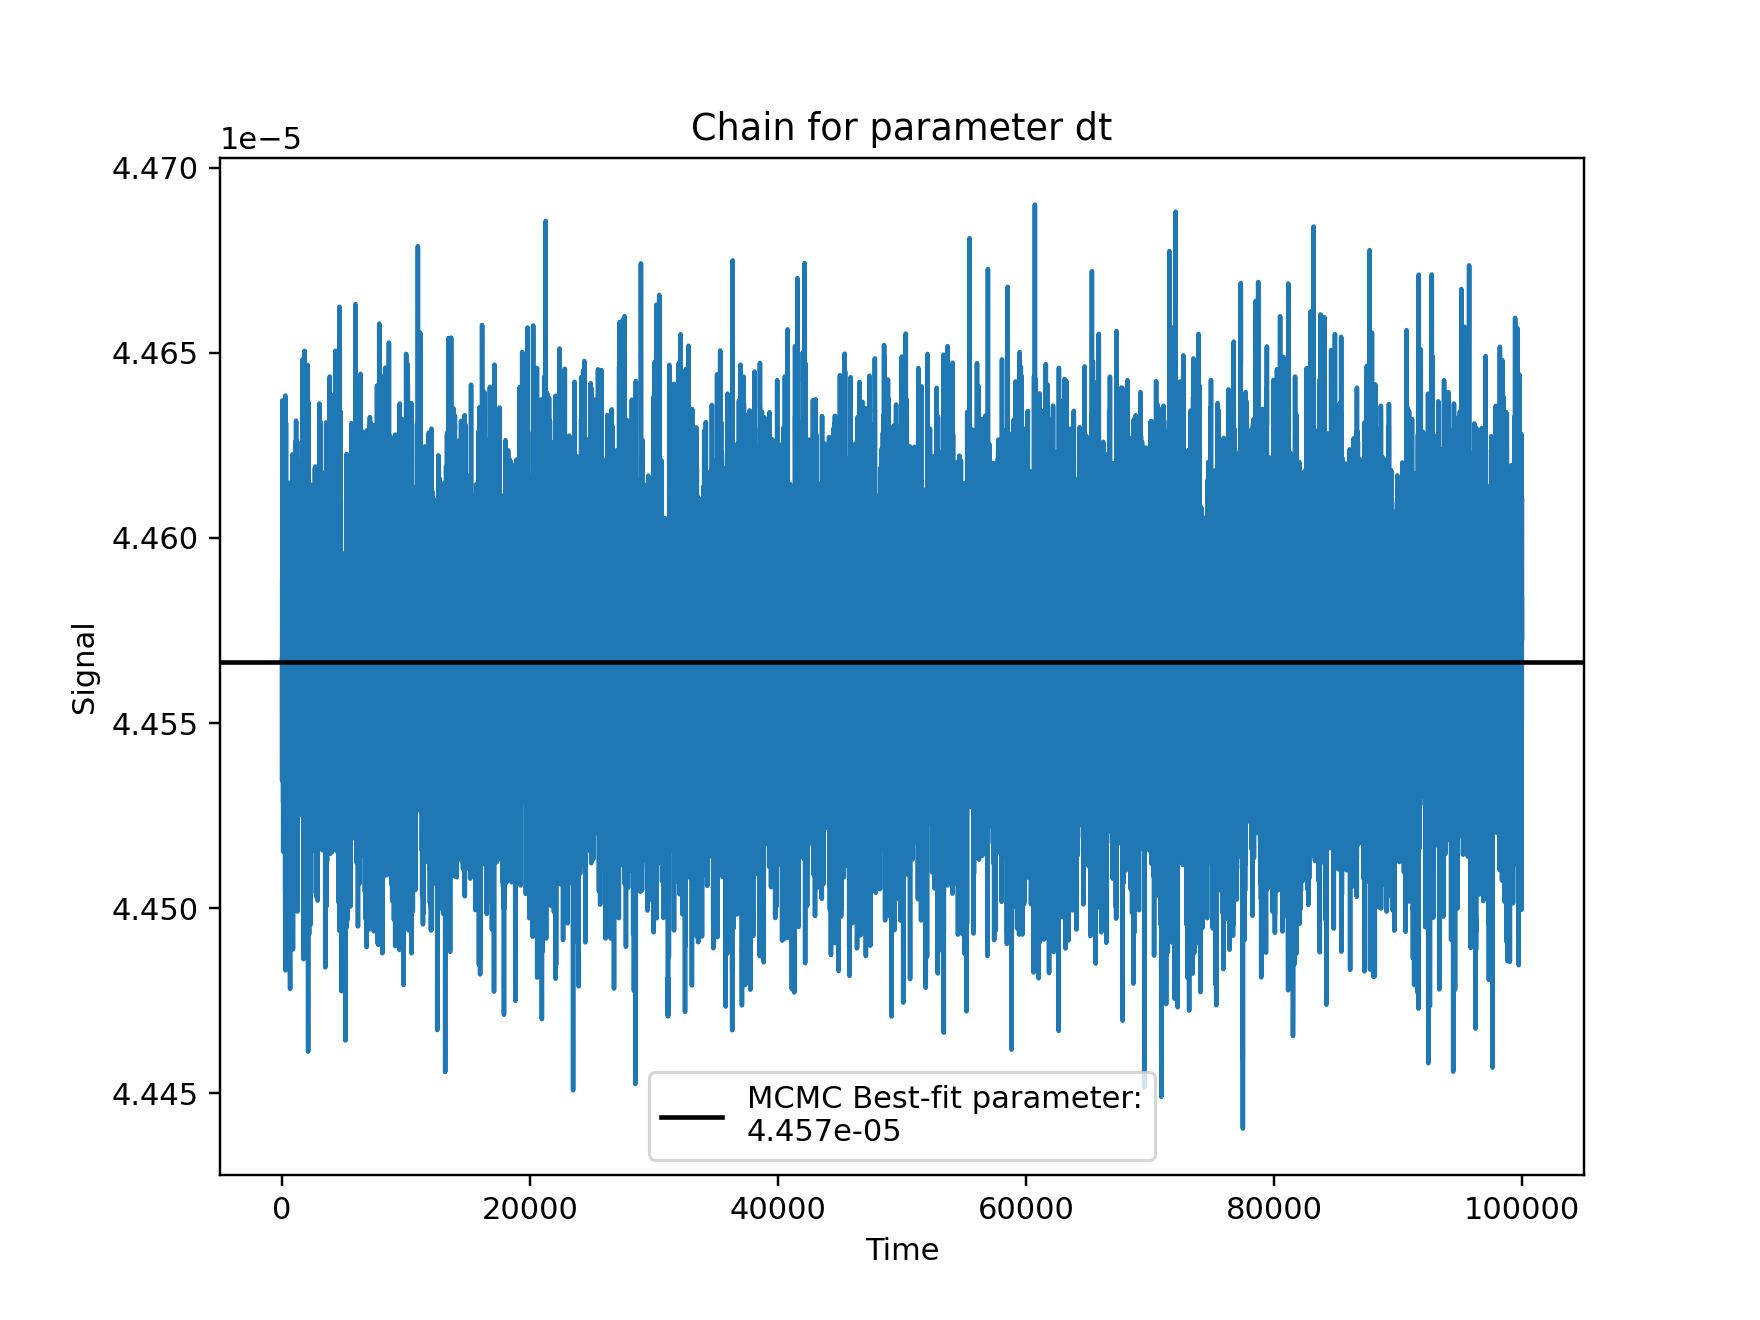

<IPython.core.display.Javascript object>


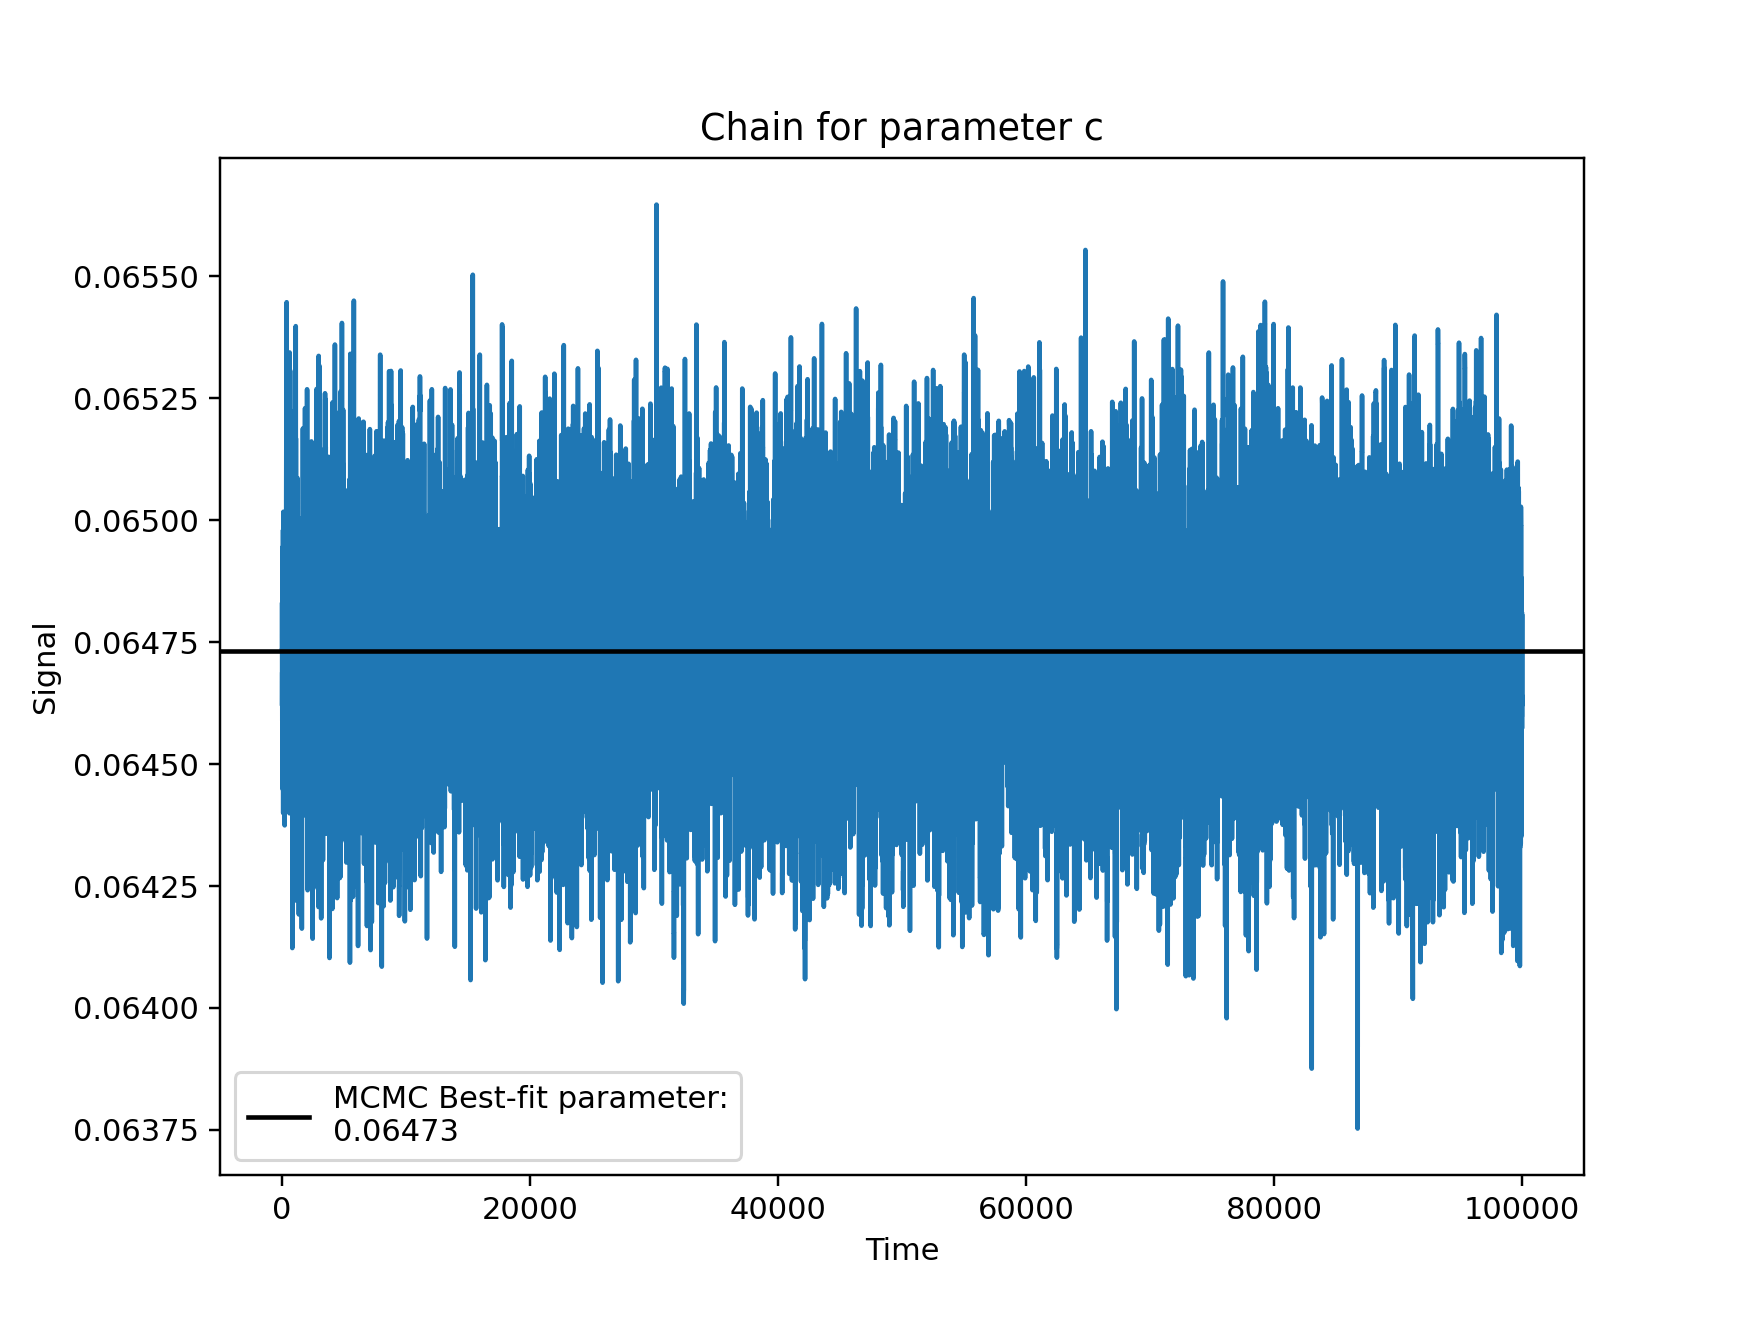

In [15]:
#We can plot the each parameters' chain to see if they converge. 
#We should expect white noise (i.e. random zig-zags centered on a flat line)
params=["a","t_0","w","b","dt","c"]
for i in range(len(chain[0])):
    plt.figure(figsize=[8,6])
    plt.plot(chain[:,i])
    plt.title('Chain for parameter {}'.format(params[i]))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    bestfit = np.mean(chain[:,i])
    plt.axhline(y=bestfit,label='MCMC Best-fit parameter:\n{}'.format(f'{bestfit:.4}'),color='k')
    plt.legend()


We can be confident with the convergence of the MCMC chain as we observe white noise for every parameters of the model!

<IPython.core.display.Javascript object>


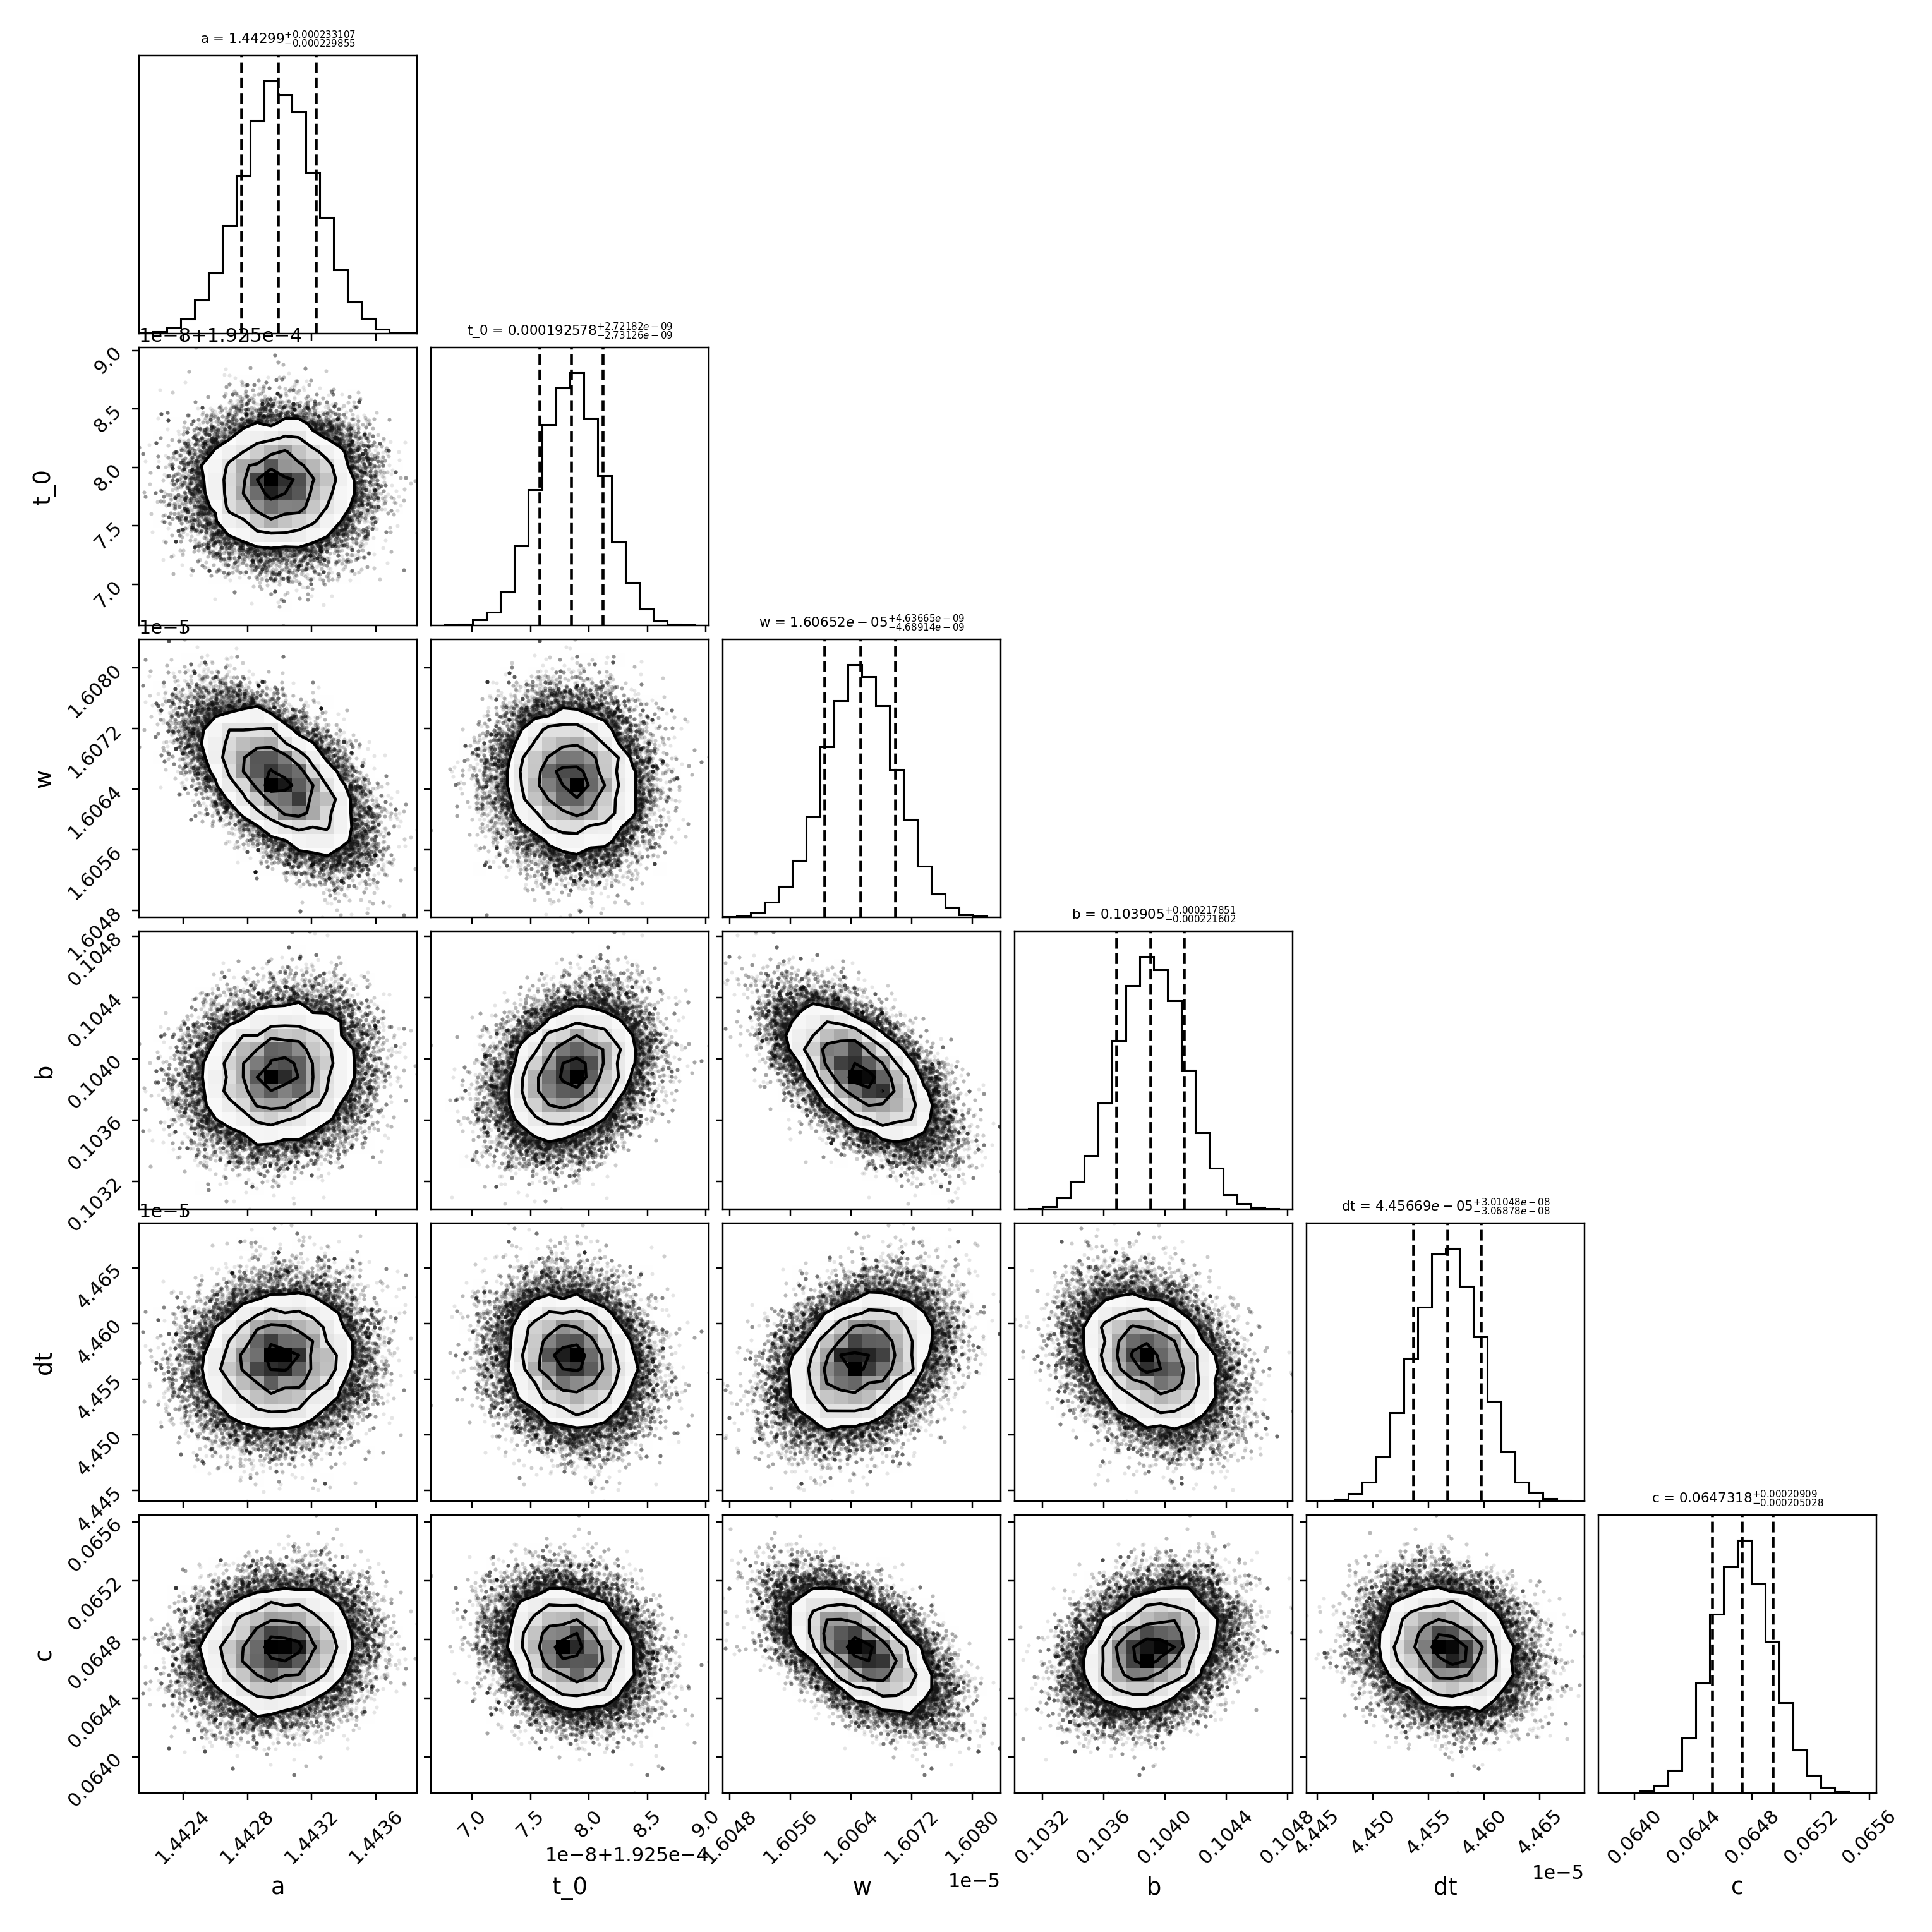

In [16]:
#We can plot the parameters covariance to visualize the correlations
#thanks to the TA for introducing corner and to Loic for sending me this little snippet of code
param_mcmc = np.mean(chain, axis=0)
corner.corner(chain,labels=params,label_kwargs=dict(fontsize=12),quantiles = [0.16,.5,.84],
              show_titles=True,title_fmt='g',title_kwargs = dict(fontsize = 7)) 
plt.show()

In [17]:
#Parameters of the MCMC with their errors
burn_phase = 0 #since we started pretty good, I assume that there is not really a case of burning here
#but for matter of generality I will add it
mean_param_mcmc = np.mean(chain[burn_phase:],axis=0)
std_param_mcmc = np.std(chain[burn_phase:],axis=0)#for MCMC the std is a good estimate of the errors of the params


print('Parameters from the {} steps MCMC, mean and std\n'.format(nstep))
print('a = {} ± {};\nb = {} ± {};\nc = {} ± {};\nt_0 = {} ± {};\ndt = {} ± {};\nw = {} ± {}'
                                                 .format(f'{mean_param_mcmc[0]:.4}',f'{std_param_mcmc[0]:.2}',
                                                         f'{mean_param_mcmc[3]:.6}',f'{std_param_mcmc[3]:.2}',
                                                         f'{mean_param_mcmc[5]:.6}',f'{std_param_mcmc[5]:.2}',
                                                         f'{mean_param_mcmc[1]:.6}',f'{std_param_mcmc[1]:.2}',
                                                         f'{mean_param_mcmc[4]:.6}',f'{std_param_mcmc[4]:.2}',
                                                         f'{mean_param_mcmc[2]:.6}',f'{std_param_mcmc[2]:.2}'))

Parameters from the 100000 steps MCMC, mean and std

a = 1.443 ± 0.00023;
b = 0.103905 ± 0.00022;
c = 0.0647318 ± 0.00021;
t_0 = 0.000192578 ± 2.7e-09;
dt = 4.45666e-05 ± 3e-08;
w = 1.60652e-05 ± 4.7e-09


<IPython.core.display.Javascript object>


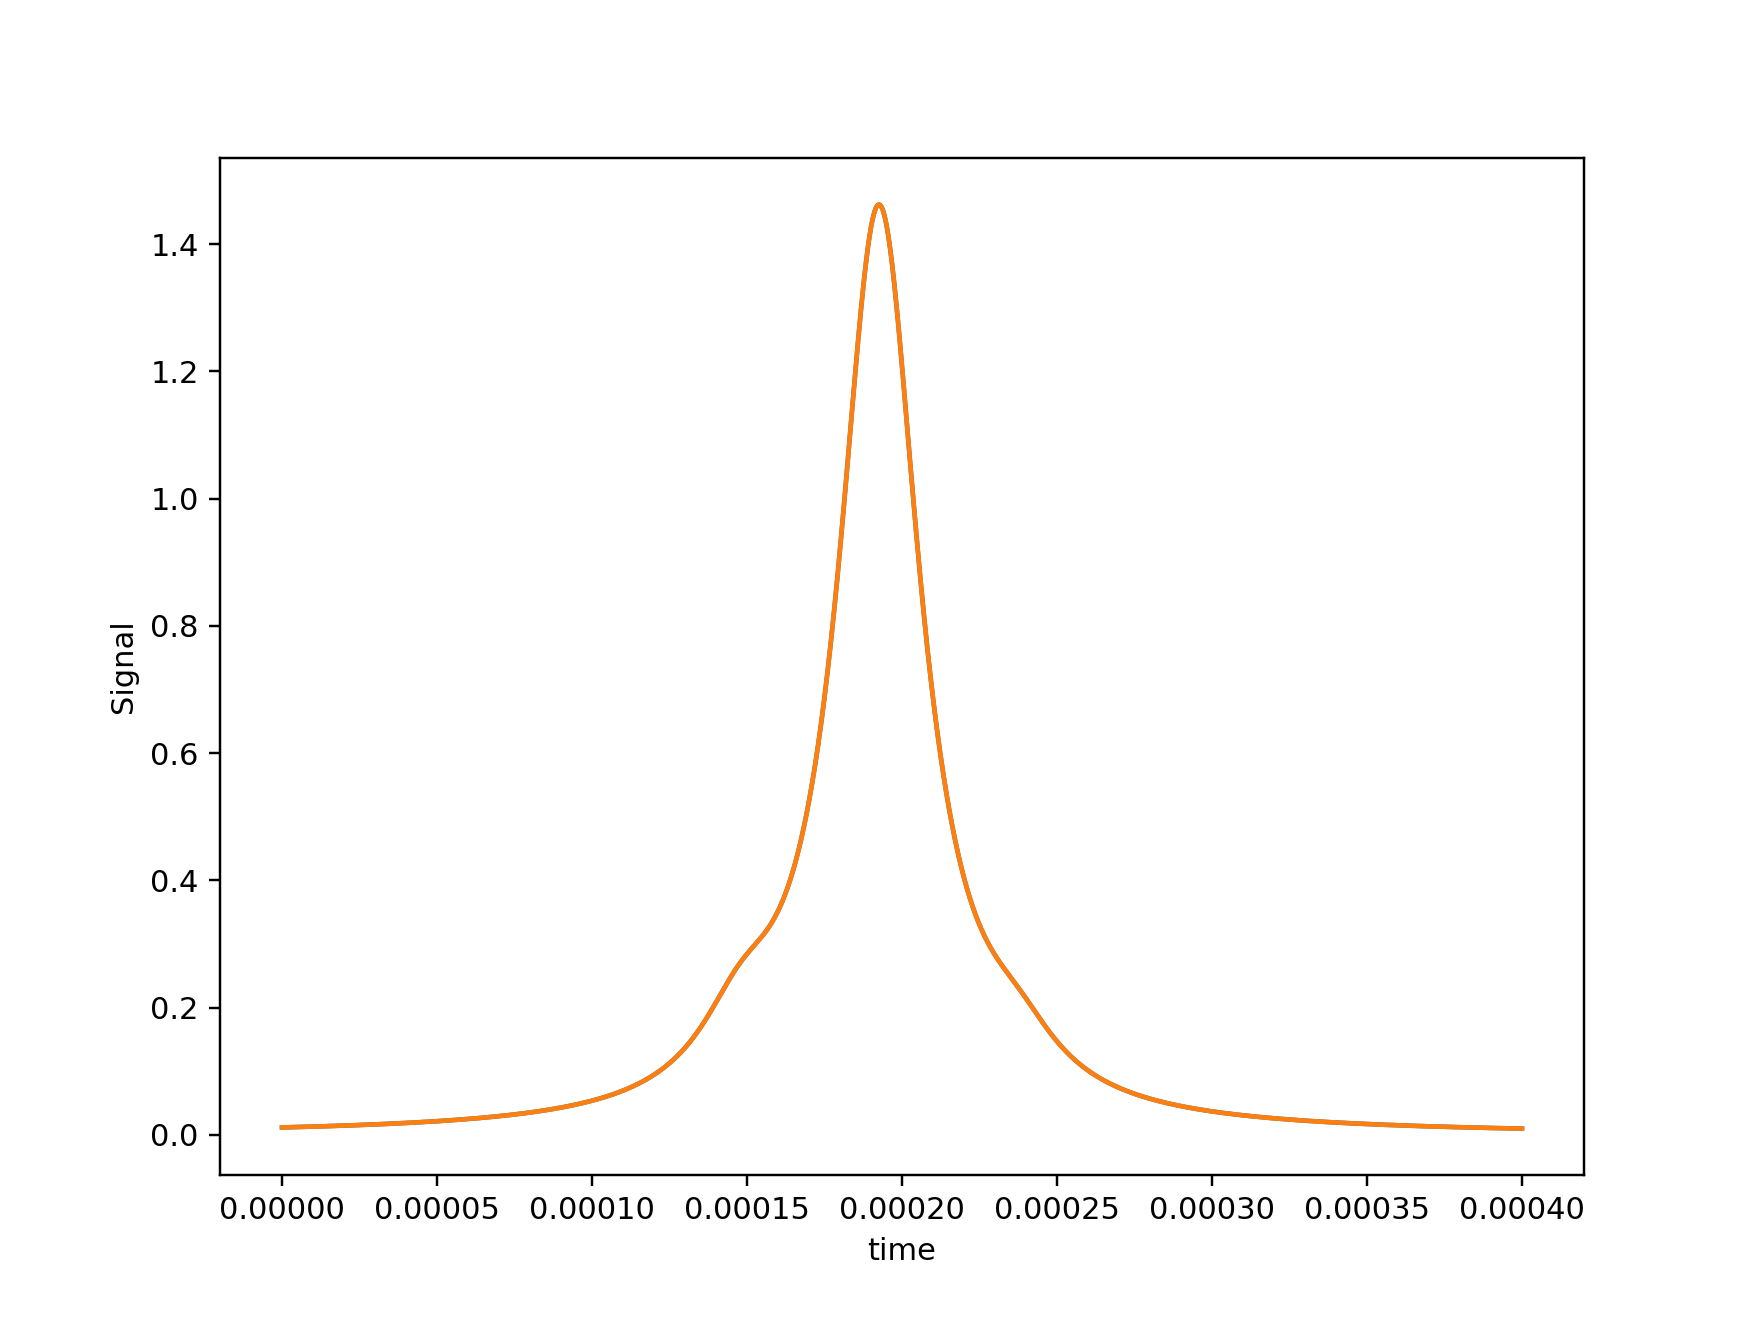

Parameter a from MCMC:1.4429919692301352, from Newtons:1.4429923665147195
with error difference (MCMC-Newton) 1.6993402531831304e-06


Parameter t_0 from MCMC:0.00019257847634985623, from Newtons:0.00019257852266908368
with error difference (MCMC-Newton) 1.4213233856260813e-11


Parameter w from MCMC:1.6065165829369306e-05, from Newtons:1.606511273226214e-05
with error difference (MCMC-Newton) -1.7134578279886078e-10


Parameter b from MCMC:0.10390455168109441, from Newtons:0.10391073229028751
with error difference (MCMC-Newton) 4.0451583820932404e-07


Parameter dt from MCMC:4.456660411067072e-05, from Newtons:4.4567200119504405e-05
with error difference (MCMC-Newton) -2.4212959204734074e-09


Parameter c from MCMC:0.06473182741558424, from Newtons:0.06473236436059851
with error difference (MCMC-Newton) -6.910265274911168e-06




In [18]:
#We can compare the MCMC with Newton's method
plt.figure(figsize=[8,6])
plt.plot(t,pred_num3)
plt.plot(t,lorentz_3(mean_param_mcmc,t))
plt.xlabel('time')
plt.ylabel('Signal')

for i in range(len(std_param_mcmc)):
    print('Parameter {} from MCMC:{}, from Newtons:{}\nwith error difference (MCMC-Newton) {}\n\n'.format(
        params[i],mean_param_mcmc[i],p_num3[i],std_param_mcmc[i]-param_err_num3[i]))
    
    

So, we can say that the two methods yield similar results and the error are pretty similar too! The error bars changed by a very little bit.

**[h]**
I think that this question simply requires to map our results (i.e. calibrate) which simply requires some rule of 3. We can perform propagation of errors to get the error of the true cavity width resonance.

In [19]:
dt = mean_param_mcmc[4]
errdt = std_param_mcmc[4]
dhz = 1/dt
true_dhz = 9e9

w = mean_param_mcmc[2]
errw = std_param_mcmc[2]
whz = 1/w
true_whz = whz*true_dhz/dhz

err = true_whz*np.sqrt(np.sum(np.array([errw/w,errdt/dt])**2))

print('The actual width of the cavity resonance is {} ± {} GHz'.format(f'{true_whz/1e9:.4}',f'{err/1e9:.1}'))

The actual width of the cavity resonance is 24.97 ± 0.02 GHz
